In [191]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
import cv2
import pandas as pd
import os


In [192]:
calc_df = pd.read_csv('../data/processed/calc_dicom.csv')
mass_df = pd.read_csv('../data/processed/mass_dicom.csv')
calc_df.head()

,subject_id,image_path,pathology
0,Calc-Test_P_00562_LEFT_CC_2,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,BENIGN_WITHOUT_CALLBACK
1,Calc-Training_P_00181_RIGHT_CC_1,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...,BENIGN
2,Calc-Training_P_01015_LEFT_CC_1,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...,MALIGNANT
3,Calc-Training_P_01497_LEFT_CC_1,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...,BENIGN
4,Calc-Test_P_00857_RIGHT_CC_1,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281604...,MALIGNANT


In [193]:
calc_df['original_image'] = calc_df['image_path'].apply(lambda x: "../data/raw/" + x )
calc_df['out_image'] = calc_df['image_path'].apply(lambda x: "../data/processed/" + x )
mass_df['original_image'] = mass_df['image_path'].apply(lambda x: "../data/raw/" + x )
mass_df['out_image'] = mass_df['image_path'].apply(lambda x: "../data/processed/" + x )

#drop image_path column
calc_df.drop(columns=['image_path'], inplace=True)
mass_df.drop(columns=['image_path'], inplace=True)

calc_df.head()

,subject_id,pathology,original_image,out_image
0,Calc-Test_P_00562_LEFT_CC_2,BENIGN_WITHOUT_CALLBACK,../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.10...,../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9...
1,Calc-Training_P_00181_RIGHT_CC_1,BENIGN,../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.10...,../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9...
2,Calc-Training_P_01015_LEFT_CC_1,MALIGNANT,../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.10...,../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9...
3,Calc-Training_P_01497_LEFT_CC_1,BENIGN,../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.10...,../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9...
4,Calc-Test_P_00857_RIGHT_CC_1,MALIGNANT,../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.10...,../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9...


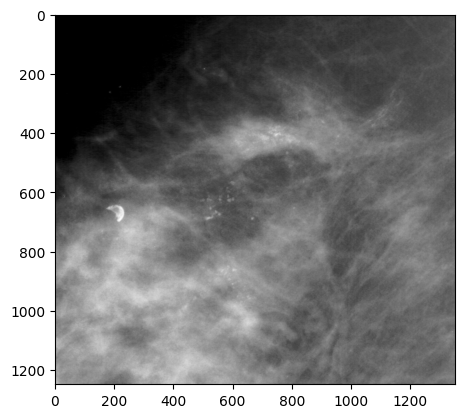

In [194]:
#plot the image BW

image = plt.imread(calc_df['original_image'][210])
plt.imshow(image, cmap='gray')
plt.show()

In [195]:
def img_pipeline(image):
    ########################################################
    #NL Means Denoising 
    #convert image to float
    f_img = img_as_float(image)

    sigma_est = np.mean(estimate_sigma(f_img, channel_axis=None))
    
    patch_kw = dict(
        patch_size=5, patch_distance=6  # 5x5 patches and 13x13 search area
    )

    # Apply fast non-local means denoising
    denoise_fast = denoise_nl_means(f_img, h=0.8 * sigma_est, fast_mode=True, **patch_kw)

    ########################################################
    #Histogram Equalization
    #convert the image to openCV
    u_denoise = np.uint8(denoise_fast*255)


    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    cl1 = clahe.apply(u_denoise)

    ########################################################
    #resize the image to 224x224
    resized = cv2.resize(cl1, (224, 224), interpolation = cv2.INTER_AREA)
    
    return resized

In [196]:
#now apply the pipeline to every image and save the output image to the out_image column creating also the directory structure
for image_path, out_image in calc_df[['original_image', 'out_image']].values:
    print("Processing: " + image_path)
    
    # Read the image
    image = plt.imread(image_path)
    
    # Apply the image processing pipeline
    out_img = img_pipeline(image)
    
    # Ensure the directory structure exists
    out_dir = os.path.dirname(out_image)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    # Save the processed image
    plt.imsave(out_image, out_img, cmap='gray')

    print(f"Saved processed image to {out_image}")

    


Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317/1-052.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317/1-052.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/1-034.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/1-034.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994714611485132105265512043047466091/1-149.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994714611485132105265512043047466091/1-149.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/1-003.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/1-003.jpg
Processing: 

In [197]:
#now apply the pipeline to every image and save the output image to the out_image column creating also the directory structure
import tqdm

#used tqdm to show the progress bar

for image_path, out_image in tqdm.tqdm(mass_df[['original_image', 'out_image']].values):
    print("Processing: " + image_path)
    
    # Read the image
    image = plt.imread(image_path)
    
    # Apply the image processing pipeline
    out_img = img_pipeline(image)
    
    # Ensure the directory structure exists
    out_dir = os.path.dirname(out_image)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    # Save the processed image
    plt.imsave(out_image, out_img, cmap='gray')

    print(f"Saved processed image to {out_image}")


  0%|          | 2/1696 [00:00<02:02, 13.82it/s]

Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/1-085.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/1-085.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008050412534761329866492500201501919/2-242.jpg


  0%|          | 4/1696 [00:00<02:13, 12.70it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008050412534761329866492500201501919/2-242.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.231894579813593468217419823840305212127/1-171.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.231894579813593468217419823840305212127/1-171.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286212602510327696024825204783459108873/1-104.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286212602510327696024825204783459108873/1-104.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.423283243012912888204847591923699853302/1-000.jpg


  0%|          | 8/1696 [00:00<02:09, 13.05it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.423283243012912888204847591923699853302/1-000.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277536201512923192140499372911328359871/1-012.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277536201512923192140499372911328359871/1-012.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48373758512808386736706922374063585453/2-213.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48373758512808386736706922374063585453/2-213.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.6045256612955420423132983594238432227/1-269.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.6045256612955420423132983594238432227/1-269.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271196701611666628735372012851189292665/1-072.jpg


  1%|          | 12/1696 [00:01<02:29, 11.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271196701611666628735372012851189292665/1-072.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.391437477411237949636827790113120275148/1-262.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.391437477411237949636827790113120275148/1-262.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.290690460212241731206899183621313608449/1-115.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.290690460212241731206899183621313608449/1-115.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215387140211542179026960032071463698827/1-287.jpg


  1%|          | 17/1696 [00:01<02:12, 12.69it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215387140211542179026960032071463698827/1-287.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136393967012487306817000462673619051519/1-071.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136393967012487306817000462673619051519/1-071.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209605321012748626627455520162879888688/1-012.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209605321012748626627455520162879888688/1-012.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.269215817811308995925548233261470082735/2-163.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.269215817811308995925548233261470082735/2-163.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209682881411918970623523621242201950465/1-236.jpg
Saved proces

  1%|          | 19/1696 [00:01<02:16, 12.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.423466000111400290224801437981990595540/1-223.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.201522562711496443720752570002776479535/2-109.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.201522562711496443720752570002776479535/2-109.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138749295211020911737612187182477571708/2-200.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138749295211020911737612187182477571708/2-200.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357722134612948294104178607601099575010/1-175.jpg


  1%|▏         | 23/1696 [00:01<02:20, 11.90it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357722134612948294104178607601099575010/1-175.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274294053310488481027210700083969292113/1-252.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274294053310488481027210700083969292113/1-252.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.379707289610326757632542844341667442069/1-065.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.379707289610326757632542844341667442069/1-065.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.180919249412973969916092916872198534127/1-297.jpg


  1%|▏         | 25/1696 [00:02<02:18, 12.03it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.180919249412973969916092916872198534127/1-297.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.113512200013908794339480175931279083002/1-192.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.113512200013908794339480175931279083002/1-192.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404062618412117123410640260402143809047/1-295.jpg


  2%|▏         | 27/1696 [00:02<02:34, 10.79it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404062618412117123410640260402143809047/1-295.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.108511516613015548417445804904165634208/2-279.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.108511516613015548417445804904165634208/2-279.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344356805711546795815193754951146394983/2-038.jpg


  2%|▏         | 31/1696 [00:02<02:30, 11.09it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344356805711546795815193754951146394983/2-038.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.278479423410397786623603601040527941872/1-204.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.278479423410397786623603601040527941872/1-204.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.172249911913244794903312682790354887670/2-267.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.172249911913244794903312682790354887670/2-267.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.122831666011537404722786976620674592384/1-280.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.122831666011537404722786976620674592384/1-280.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.156677045212582535642837441353121866537/1-032.jpg


  2%|▏         | 33/1696 [00:02<02:24, 11.52it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.156677045212582535642837441353121866537/1-032.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162885775213445442821484972950448242505/2-124.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162885775213445442821484972950448242505/2-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.401214379512684833222439968160756943149/2-105.jpg


  2%|▏         | 35/1696 [00:03<02:39, 10.43it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.401214379512684833222439968160756943149/2-105.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196479284412458694937158936674285398162/1-116.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196479284412458694937158936674285398162/1-116.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159557093312261526437237114213678011350/1-161.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159557093312261526437237114213678011350/1-161.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.58678001112693422121422322294162648005/2-093.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.58678001112693422121422322294162648005/2-093.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.109202716612382008529359592121254138576/1-049.jpg


  2%|▏         | 38/1696 [00:03<02:02, 13.54it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.109202716612382008529359592121254138576/1-049.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.197346252612402417607685923081598641765/1-131.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.197346252612402417607685923081598641765/1-131.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236812839312613914436445183062633981411/1-237.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236812839312613914436445183062633981411/1-237.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272420956211500194613015855910561320194/1-153.jpg


  3%|▎         | 43/1696 [00:03<01:55, 14.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272420956211500194613015855910561320194/1-153.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121844987912199968113589579754023493214/2-021.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121844987912199968113589579754023493214/2-021.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67196722111199501007723550042354392513/1-024.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67196722111199501007723550042354392513/1-024.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.183250739910949037237308684010112484798/1-094.jpg


  3%|▎         | 45/1696 [00:03<02:04, 13.23it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.183250739910949037237308684010112484798/1-094.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.362737852710203464022705977903812790645/1-266.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.362737852710203464022705977903812790645/1-266.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173483617113726468207465153320865645482/1-200.jpg


  3%|▎         | 47/1696 [00:04<03:54,  7.02it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173483617113726468207465153320865645482/1-200.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413088469711470025941886931291637990823/2-227.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413088469711470025941886931291637990823/2-227.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.158042867812068617423641000180830977034/1-110.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.158042867812068617423641000180830977034/1-110.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141791691712603638940173252021006799125/2-224.jpg


  3%|▎         | 51/1696 [00:04<02:57,  9.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141791691712603638940173252021006799125/2-224.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175886582313568715400708524902994803805/1-072.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175886582313568715400708524902994803805/1-072.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.86254599111567721135368096072734935094/1-059.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.86254599111567721135368096072734935094/1-059.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199872781413275649323938881652250087248/2-192.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199872781413275649323938881652250087248/2-192.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11976364312018642742192444363220866070/1-064.jpg


  3%|▎         | 54/1696 [00:04<02:13, 12.29it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11976364312018642742192444363220866070/1-064.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247686453312806717421635544732731976519/1-120.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247686453312806717421635544732731976519/1-120.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.388636067512527636836953061311268483123/2-155.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.388636067512527636836953061311268483123/2-155.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213709339211989106238645984553320169440/1-163.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213709339211989106238645984553320169440/1-163.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270964980412538159307361770414010109388/2-174.jpg


  3%|▎         | 57/1696 [00:04<01:58, 13.88it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270964980412538159307361770414010109388/2-174.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.298395396913193633428106412961761545595/1-014.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.298395396913193633428106412961761545595/1-014.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.310354580112648215506863264034185988534/1-078.jpg


  4%|▎         | 61/1696 [00:05<02:04, 13.11it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.310354580112648215506863264034185988534/1-078.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.145004588811682866632519177113509909329/1-004.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.145004588811682866632519177113509909329/1-004.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398266572012522112736467293691708196145/1-053.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398266572012522112736467293691708196145/1-053.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345522512011144937217670143263509609355/1-202.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345522512011144937217670143263509609355/1-202.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54083065310693877418895561211039571030/1-174.jpg


  4%|▍         | 65/1696 [00:05<02:01, 13.44it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54083065310693877418895561211039571030/1-174.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.376065578012810917910810451392263640984/2-153.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.376065578012810917910810451392263640984/2-153.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424325096511908521711852484042496710975/1-279.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424325096511908521711852484042496710975/1-279.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334648433711627325917972218213128352457/2-271.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334648433711627325917972218213128352457/2-271.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132637148911095422914884453692797165079/1-230.jpg
Saved process

  4%|▍         | 70/1696 [00:05<01:43, 15.71it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233698851511609444906681501734065632813/1-212.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196398184912033488622945934210693879222/2-294.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196398184912033488622945934210693879222/2-294.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.106588546212208683524717162253577510837/2-097.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.106588546212208683524717162253577510837/2-097.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265611533010846495727116535192635229344/2-283.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265611533010846495727116535192635229344/2-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.306532397312231245707190473473419369804/1-071.jpg


  4%|▍         | 74/1696 [00:06<01:50, 14.63it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.306532397312231245707190473473419369804/1-071.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166951813611052640111096754553137342918/2-093.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166951813611052640111096754553137342918/2-093.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282977447212059741734758964482951094442/1-207.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282977447212059741734758964482951094442/1-207.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281160244512696906237812213023711879059/1-214.jpg


  4%|▍         | 76/1696 [00:06<02:09, 12.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281160244512696906237812213023711879059/1-214.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.122706985411446472401146362143620569675/1-284.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.122706985411446472401146362143620569675/1-284.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37780003410078783314486532443985436571/2-080.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37780003410078783314486532443985436571/2-080.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.383106931112571205227813146982972889681/1-281.jpg


  5%|▍         | 78/1696 [00:06<02:43,  9.91it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.383106931112571205227813146982972889681/1-281.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.275816481412474587121235649780524516857/2-287.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.275816481412474587121235649780524516857/2-287.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271766004813533818834432213950296794827/1-230.jpg


  5%|▍         | 80/1696 [00:06<02:55,  9.23it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271766004813533818834432213950296794827/1-230.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.190371998012909216226366286144226107826/1-058.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.190371998012909216226366286144226107826/1-058.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.15585812611753556418530044203326204631/2-012.jpg


  5%|▍         | 84/1696 [00:07<02:31, 10.62it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.15585812611753556418530044203326204631/2-012.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2384234710251054107522753430374290347/2-261.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2384234710251054107522753430374290347/2-261.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50631654813156170442539396462000816513/2-074.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50631654813156170442539396462000816513/2-074.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.393707185513959554524123170961270881067/2-188.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.393707185513959554524123170961270881067/2-188.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141034675411749095310932130682199416361/1-083.jpg


  5%|▌         | 89/1696 [00:07<01:49, 14.63it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141034675411749095310932130682199416361/1-083.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293186695712418317826410436081321367919/1-104.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293186695712418317826410436081321367919/1-104.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68530981111298511433726816353081765969/1-182.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68530981111298511433726816353081765969/1-182.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.95061281512103200539121122973928626905/1-060.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.95061281512103200539121122973928626905/1-060.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.297789759910579928235153197293591687373/1-070.jpg


  6%|▌         | 94/1696 [00:07<01:40, 15.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.297789759910579928235153197293591687373/1-070.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221421638613333700829316122941612334427/1-087.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221421638613333700829316122941612334427/1-087.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345309220211676554635929778040975737650/1-036.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345309220211676554635929778040975737650/1-036.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336071559511064328718791448490558949969/1-233.jpg
Saved proces

  6%|▌         | 96/1696 [00:08<01:53, 14.13it/s]

Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415539666013115713838793314692523355493/2-196.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415539666013115713838793314692523355493/2-196.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.298648398112853530923210871563609947010/1-090.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.298648398112853530923210871563609947010/1-090.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424889390711092892018162257160068574314/1-099.jpg


  6%|▌         | 99/1696 [00:08<01:38, 16.16it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424889390711092892018162257160068574314/1-099.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411168598811470485327252253942390358505/2-096.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411168598811470485327252253942390358505/2-096.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.360600165213329661134949692543503873832/1-105.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.360600165213329661134949692543503873832/1-105.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.322573177011773799542349690022231384456/1-299.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.322573177011773799542349690022231384456/1-299.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.45105785611794396517463922110362076816/1-151.jpg


  6%|▌         | 101/1696 [00:08<02:25, 10.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.45105785611794396517463922110362076816/1-151.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335650228110147472419612611852837629658/1-037.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335650228110147472419612611852837629658/1-037.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367577797410545669023355319140158622212/1-006.jpg


  6%|▌         | 103/1696 [00:08<02:30, 10.57it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367577797410545669023355319140158622212/1-006.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209697303710902279801410290493638607923/2-222.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209697303710902279801410290493638607923/2-222.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422957282012810013841418684460061208674/1-022.jpg


  6%|▌         | 105/1696 [00:09<03:32,  7.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422957282012810013841418684460061208674/1-022.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314202752110860447319821482722631603171/1-282.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314202752110860447319821482722631603171/1-282.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403358717113527849111437349360275414259/2-296.jpg


  6%|▋         | 110/1696 [00:09<02:57,  8.92it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403358717113527849111437349360275414259/2-296.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344244298112027209533481291843681547544/2-120.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344244298112027209533481291843681547544/2-120.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67609098512679403432428254042416854686/1-142.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67609098512679403432428254042416854686/1-142.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314897276811732626217434331163305836897/2-001.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314897276811732626217434331163305836897/2-001.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.400549737411618952827950975203925268829/1-189.jpg


  7%|▋         | 115/1696 [00:10<02:10, 12.13it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.400549737411618952827950975203925268829/1-189.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422898989410333062402705791044133714485/1-162.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422898989410333062402705791044133714485/1-162.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.113405301511327820306701628183448202206/1-006.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.113405301511327820306701628183448202206/1-006.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237350682012751576100927118523700516035/2-283.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237350682012751576100927118523700516035/2-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.146230996611453048512904009510459305140/1-285.jpg
Saved proces

  7%|▋         | 117/1696 [00:10<02:07, 12.34it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.348849211010660844509631430942686825269/1-091.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.361187641612044722920735361310877600748/2-200.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.361187641612044722920735361310877600748/2-200.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.246130090311553315234482668904181393758/2-150.jpg


  7%|▋         | 121/1696 [00:10<02:20, 11.23it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.246130090311553315234482668904181393758/2-150.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288750095111620690127940276520877836108/1-101.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288750095111620690127940276520877836108/1-101.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.324309622011475628318154737932701357211/2-160.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.324309622011475628318154737932701357211/2-160.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.51457123011337046939870076193775211718/1-146.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.51457123011337046939870076193775211718/1-146.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.218263190511090313139086250803890584117/2-217.jpg
Saved processe

  7%|▋         | 125/1696 [00:10<02:15, 11.55it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175852960712358343316382736692949183507/1-280.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.383285919712986381706460438071667571219/2-210.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.383285919712986381706460438071667571219/2-210.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.10658885911501181010386825340527343068/1-010.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.10658885911501181010386825340527343068/1-010.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.391195498012104141006460448243492391195/1-222.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.391195498012104141006460448243492391195/1-222.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271414424911670964506067728680989711189/2-225.jpg


  8%|▊         | 129/1696 [00:11<01:55, 13.59it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271414424911670964506067728680989711189/2-225.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.320693689810782044906578213673576310905/1-170.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.320693689810782044906578213673576310905/1-170.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.323291677311591228208438770392577269840/1-144.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.323291677311591228208438770392577269840/1-144.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.96511975911876292931610031542715440172/1-055.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.96511975911876292931610031542715440172/1-055.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.310417008311970894938815230770265106023/2-270.jpg


  8%|▊         | 133/1696 [00:11<02:04, 12.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.310417008311970894938815230770265106023/2-270.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265708461310696308514982120193169816782/1-176.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265708461310696308514982120193169816782/1-176.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334264328811472580216194328743547952403/1-129.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334264328811472580216194328743547952403/1-129.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136356543710283494330369458242898573528/1-128.jpg


  8%|▊         | 135/1696 [00:11<02:17, 11.39it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136356543710283494330369458242898573528/1-128.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.75915096813909549403343655801659493741/2-298.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.75915096813909549403343655801659493741/2-298.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.29318932712695951431444118093650037083/1-033.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.29318932712695951431444118093650037083/1-033.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309008803712151034042556394480768984762/2-039.jpg


  8%|▊         | 139/1696 [00:12<01:55, 13.52it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309008803712151034042556394480768984762/2-039.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.52258729211553633726350106974257225965/1-209.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.52258729211553633726350106974257225965/1-209.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.78953662012289228020056948630934822284/1-238.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.78953662012289228020056948630934822284/1-238.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.78314938912059020203440103860685003992/1-031.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.78314938912059020203440103860685003992/1-031.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.143813222312398331821338710380855308042/1-291.jpg


  8%|▊         | 143/1696 [00:12<02:30, 10.30it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.143813222312398331821338710380855308042/1-291.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.414422747910982358008788584120329514207/2-233.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.414422747910982358008788584120329514207/2-233.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176867308511210550210386646393087213459/1-129.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176867308511210550210386646393087213459/1-129.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53701446512313340322746385173956683456/1-061.jpg


  9%|▊         | 145/1696 [00:12<02:37,  9.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53701446512313340322746385173956683456/1-061.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.337889068912217823622466563932018789324/2-297.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.337889068912217823622466563932018789324/2-297.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.380616930711845654525930515792575143339/2-021.jpg


  9%|▊         | 147/1696 [00:13<03:40,  7.01it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.380616930711845654525930515792575143339/2-021.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374467146111101869235379099101911987377/2-197.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374467146111101869235379099101911987377/2-197.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273583962611358776237919717661223592624/2-013.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273583962611358776237919717661223592624/2-013.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.412862240411725259842309390381988811103/2-196.jpg


  9%|▉         | 151/1696 [00:13<02:50,  9.07it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.412862240411725259842309390381988811103/2-196.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.315125145610617342117509244450818889685/2-202.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.315125145610617342117509244450818889685/2-202.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.188687509410618341802747273162629893320/1-212.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.188687509410618341802747273162629893320/1-212.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26316563411345028623201688773824119915/2-262.jpg


  9%|▉         | 153/1696 [00:13<02:30, 10.24it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26316563411345028623201688773824119915/2-262.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.5443013411725375126198864850093120508/1-123.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.5443013411725375126198864850093120508/1-123.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.301805576312136110926505701523451263527/1-027.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.301805576312136110926505701523451263527/1-027.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.98869608012141056833257796120597025392/1-089.jpg


  9%|▉         | 155/1696 [00:13<02:24, 10.68it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.98869608012141056833257796120597025392/1-089.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.103369236313674273230856562131142295728/1-076.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.103369236313674273230856562131142295728/1-076.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248115994912525429104448387842986945186/2-244.jpg


  9%|▉         | 160/1696 [00:14<02:05, 12.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248115994912525429104448387842986945186/2-244.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163728385610236612224129350812278611535/2-062.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163728385610236612224129350812278611535/2-062.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331295433311276525933663133590565317152/1-092.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331295433311276525933663133590565317152/1-092.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.87873763812450520319229641093375687838/2-079.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.87873763812450520319229641093375687838/2-079.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387883815711770815502763636591812789251/1-185.jpg


 10%|▉         | 162/1696 [00:14<02:22, 10.78it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387883815711770815502763636591812789251/1-185.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370047058411160509216337197304234192394/1-057.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370047058411160509216337197304234192394/1-057.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.400729554413074689124679520180413295981/2-080.jpg


 10%|▉         | 164/1696 [00:14<02:15, 11.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.400729554413074689124679520180413295981/2-080.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.83922906010046159016146177544009704460/2-215.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.83922906010046159016146177544009704460/2-215.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284195333512847807316022877833484395283/2-145.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284195333512847807316022877833484395283/2-145.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205325917611740340809857473902592922020/2-154.jpg


 10%|▉         | 168/1696 [00:15<02:18, 11.02it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205325917611740340809857473902592922020/2-154.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171032117812726379616583630302604707467/1-243.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171032117812726379616583630302604707467/1-243.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132822860511992519317776009000394221499/1-216.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132822860511992519317776009000394221499/1-216.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.45333568212207677414965738353738652576/2-169.jpg


 10%|█         | 174/1696 [00:15<01:39, 15.34it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.45333568212207677414965738353738652576/2-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212059315612165119641080329433602828486/2-168.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212059315612165119641080329433602828486/2-168.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312484986211624832205000935803744799999/1-125.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312484986211624832205000935803744799999/1-125.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.421655962713561385939752534200837655338/1-041.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.421655962713561385939752534200837655338/1-041.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93534288513896114033088667362226729905/2-199.jpg
Saved processe

 11%|█         | 179/1696 [00:15<01:45, 14.35it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.394770329712127335215198368031088501156/2-143.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196869489211799063911582424382646068510/1-075.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196869489211799063911582424382646068510/1-075.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.305608761311452355602792766720481770937/1-029.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.305608761311452355602792766720481770937/1-029.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.51184847912600641827700251082226435484/1-043.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.51184847912600641827700251082226435484/1-043.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.177802689811855630641145427250188754798/1-046.jpg


 11%|█         | 181/1696 [00:15<01:52, 13.42it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.177802689811855630641145427250188754798/1-046.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194611106313167055136962408020077776809/1-073.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194611106313167055136962408020077776809/1-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.49997917211997806926886603772039315476/1-294.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.49997917211997806926886603772039315476/1-294.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176913724811537446011866935530296069877/1-235.jpg


 11%|█         | 186/1696 [00:16<01:35, 15.76it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176913724811537446011866935530296069877/1-235.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104944194212313762609859567794212330218/1-227.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104944194212313762609859567794212330218/1-227.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288153362111736388134863963471171051300/2-072.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288153362111736388134863963471171051300/2-072.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213055477011614464512849059040123864462/2-196.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213055477011614464512849059040123864462/2-196.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.147431852412216742204774465553927639893/1-095.jpg
Saved proces

 11%|█         | 189/1696 [00:16<01:26, 17.45it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.155107802112769556437698410352766024997/2-234.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334693589113039749800224016960397720534/1-025.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334693589113039749800224016960397720534/1-025.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215388847611684715918592451941410519178/1-082.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215388847611684715918592451941410519178/1-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302613016812762035318087825034232716010/1-208.jpg


 11%|█▏        | 193/1696 [00:16<01:52, 13.36it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302613016812762035318087825034232716010/1-208.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.223656883912045807831677249332617654361/1-115.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.223656883912045807831677249332617654361/1-115.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235257799411541517316524673800242200135/1-291.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235257799411541517316524673800242200135/1-291.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.340902307911649457115110271134222437704/2-062.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.340902307911649457115110271134222437704/2-062.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.174667765010114515101664703094002685177/1-040.jpg
Saved proces

 12%|█▏        | 199/1696 [00:17<01:26, 17.35it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211047614012920751420673079141493934140/1-266.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.392521265211049497503641929252775059444/1-081.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.392521265211049497503641929252775059444/1-081.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.208219273913424898017061999780007737402/2-100.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.208219273913424898017061999780007737402/2-100.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.20702791512928575311782893102880193679/2-175.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.20702791512928575311782893102880193679/2-175.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.106469713711967596836488505611802834185/2-265.jpg


 12%|█▏        | 201/1696 [00:17<01:47, 13.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.106469713711967596836488505611802834185/2-265.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43200967010970030541540261333770476605/2-184.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43200967010970030541540261333770476605/2-184.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166651179313952213429624633730777625083/1-136.jpg


 12%|█▏        | 203/1696 [00:17<01:42, 14.52it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166651179313952213429624633730777625083/1-136.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.308540817510816144939801819142526237116/1-099.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.308540817510816144939801819142526237116/1-099.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355127472712403304314624541740404650609/2-019.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355127472712403304314624541740404650609/2-019.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.311132814312615054403783067432154879476/1-209.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.311132814312615054403783067432154879476/1-209.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173487175712986795121436542873145525269/1-229.jpg


 12%|█▏        | 206/1696 [00:17<01:38, 15.13it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173487175712986795121436542873145525269/1-229.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250580549713037595829242331282759055654/1-177.jpg


 12%|█▏        | 208/1696 [00:17<01:59, 12.41it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250580549713037595829242331282759055654/1-177.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.339087009912131470937640175810319897333/2-269.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.339087009912131470937640175810319897333/2-269.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126781186913766854307439581580291836768/1-102.jpg


 12%|█▏        | 210/1696 [00:18<02:29,  9.93it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126781186913766854307439581580291836768/1-102.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4356497311475610233941088031476573127/1-014.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4356497311475610233941088031476573127/1-014.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.409200990110466416215781546621650433721/1-237.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.409200990110466416215781546621650433721/1-237.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.254830555613359911614823837744282171458/2-193.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.254830555613359911614823837744282171458/2-193.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92625977011874636004018945600136848409/1-026.jpg


 13%|█▎        | 215/1696 [00:18<02:01, 12.17it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92625977011874636004018945600136848409/1-026.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213923189612009468827338377582033345163/1-280.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213923189612009468827338377582033345163/1-280.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.172679820511585449200355969312884998389/2-252.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.172679820511585449200355969312884998389/2-252.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331828654011758947930839827374231003829/1-252.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331828654011758947930839827374231003829/1-252.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101063292413216247018662637363163925430/1-064.jpg


 13%|█▎        | 219/1696 [00:18<01:44, 14.10it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101063292413216247018662637363163925430/1-064.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210604569211177131520271008481012270185/2-103.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210604569211177131520271008481012270185/2-103.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334573074812706485505698039213419799542/2-200.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334573074812706485505698039213419799542/2-200.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.91848545911005523541209798760943510196/1-168.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.91848545911005523541209798760943510196/1-168.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259172840011201321837687875911695260516/2-294.jpg


 13%|█▎        | 223/1696 [00:18<01:53, 13.02it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259172840011201321837687875911695260516/2-294.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221898644811330022503208746271520759890/2-217.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221898644811330022503208746271520759890/2-217.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413669876712652391512191407873922574883/1-117.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413669876712652391512191407873922574883/1-117.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205826898113630199908418083061888658721/1-018.jpg


 13%|█▎        | 225/1696 [00:19<02:23, 10.22it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205826898113630199908418083061888658721/1-018.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.97236402913553087828237413621604953031/1-051.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.97236402913553087828237413621604953031/1-051.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.45131627713144582424202640662752027993/1-118.jpg


 13%|█▎        | 227/1696 [00:19<02:44,  8.95it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.45131627713144582424202640662752027993/1-118.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332921884313361268429213728330957943425/1-160.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332921884313361268429213728330957943425/1-160.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129406041612334423603149103982541993290/1-164.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129406041612334423603149103982541993290/1-164.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261563112911930807513350544711445999750/2-292.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261563112911930807513350544711445999750/2-292.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186806866813490204636667688024283539312/1-181.jpg


 14%|█▎        | 232/1696 [00:19<02:00, 12.11it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186806866813490204636667688024283539312/1-181.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.77391350612919093242582778213778105346/1-224.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.77391350612919093242582778213778105346/1-224.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22326887011227963702159533191468776297/1-083.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22326887011227963702159533191468776297/1-083.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.315911877812396757514805955883366749551/1-129.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.315911877812396757514805955883366749551/1-129.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375319587411015946201453923033781478743/1-000.jpg


 14%|█▍        | 237/1696 [00:20<01:30, 16.04it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375319587411015946201453923033781478743/1-000.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.76522398913869440023256183451934189617/1-088.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.76522398913869440023256183451934189617/1-088.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.28288434812371789322754195204092975239/1-162.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.28288434812371789322754195204092975239/1-162.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277277002311039381819362164753220552653/1-045.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277277002311039381819362164753220552653/1-045.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43665767012035310007732414810147712942/2-112.jpg
Saved processed i

 14%|█▍        | 243/1696 [00:20<01:15, 19.33it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221148835811445187335709283083473562096/2-280.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176147061012109716001735110700691714998/2-135.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176147061012109716001735110700691714998/2-135.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226522745110775859610559719692823247866/1-009.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226522745110775859610559719692823247866/1-009.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247842049013790350501636015890767326415/1-034.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247842049013790350501636015890767326415/1-034.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.379858858912217148525608311402161208311/1-090.jpg
Saved proces

 15%|█▍        | 246/1696 [00:20<01:29, 16.22it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415818851911516929741887307891682111149/2-099.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126829679610945039830280296131271285440/2-177.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126829679610945039830280296131271285440/2-177.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407517678211924472933141080803080969072/1-066.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407517678211924472933141080803080969072/1-066.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4535392912042656311972857963053813964/2-006.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4535392912042656311972857963053813964/2-006.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.42458779312676658533788074462532808038/1-285.jpg
Saved processed i

 15%|█▍        | 250/1696 [00:21<02:29,  9.66it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.139243979912028599823478596370693036615/2-099.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.363789891811240091407765876570226862364/2-140.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.363789891811240091407765876570226862364/2-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175722182613918893224182793512942838747/1-281.jpg


 15%|█▍        | 254/1696 [00:21<02:18, 10.41it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175722182613918893224182793512942838747/1-281.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213474472213933616703682366720906656921/1-056.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213474472213933616703682366720906656921/1-056.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.216358103712343824536326814051645781851/2-066.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.216358103712343824536326814051645781851/2-066.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.382161872912744789714360820701966974210/2-152.jpg


 15%|█▌        | 256/1696 [00:21<02:27,  9.79it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.382161872912744789714360820701966974210/2-152.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215523771712142269418380842560270311029/1-007.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215523771712142269418380842560270311029/1-007.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404051289712034032002348776033776256148/1-076.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404051289712034032002348776033776256148/1-076.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74220062511401077210871386881822002785/2-223.jpg


 15%|█▌        | 261/1696 [00:22<01:51, 12.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74220062511401077210871386881822002785/2-223.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.42615123112846587420486229992978116905/1-020.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.42615123112846587420486229992978116905/1-020.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.147346148813590795726173738851936428101/2-280.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.147346148813590795726173738851936428101/2-280.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.87747304813106768832465470981961783228/1-070.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.87747304813106768832465470981961783228/1-070.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332971390911248752026271123792534962950/1-017.jpg


 16%|█▌        | 265/1696 [00:22<01:45, 13.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332971390911248752026271123792534962950/1-017.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186327494411516593004575993602150635295/1-081.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186327494411516593004575993602150635295/1-081.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68600592610457782338255412980087952098/1-181.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68600592610457782338255412980087952098/1-181.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64411509111134375125814659942789076813/1-020.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64411509111134375125814659942789076813/1-020.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.426943805311990016207064454964269155463/1-239.jpg


 16%|█▌        | 269/1696 [00:22<01:35, 14.92it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.426943805311990016207064454964269155463/1-239.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232655664111867764900916015764258363014/1-227.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232655664111867764900916015764258363014/1-227.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59807174411461248123448447121065500011/2-182.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59807174411461248123448447121065500011/2-182.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.224596063111590108517713919203417309235/1-110.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.224596063111590108517713919203417309235/1-110.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.416567927211826776012333072673345141427/2-268.jpg


 16%|█▌        | 272/1696 [00:22<01:25, 16.64it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.416567927211826776012333072673345141427/2-268.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256092653510382439619272441782239245199/1-231.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256092653510382439619272441782239245199/1-231.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328562269210429133327752295793440681562/1-211.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328562269210429133327752295793440681562/1-211.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368114466512227422920092425383571922380/1-093.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368114466512227422920092425383571922380/1-093.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219604667012858753519767878572948512483/1-089.jpg


 16%|█▋        | 276/1696 [00:23<01:34, 15.10it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219604667012858753519767878572948512483/1-089.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325966417613742936321163555014008553282/2-138.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325966417613742936321163555014008553282/2-138.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74351343711650842507206772644172627457/1-277.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74351343711650842507206772644172627457/1-277.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163022583512798382712837787202903855830/1-016.jpg


 16%|█▋        | 278/1696 [00:23<01:33, 15.19it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163022583512798382712837787202903855830/1-016.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.378444115012230886324003447251795950354/2-235.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.378444115012230886324003447251795950354/2-235.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.130246768212438347412703328321645776947/1-174.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.130246768212438347412703328321645776947/1-174.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.311313415912769148235686849460609112304/2-037.jpg


 17%|█▋        | 282/1696 [00:23<02:04, 11.36it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.311313415912769148235686849460609112304/2-037.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375021222710386537204756102772683691129/2-009.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375021222710386537204756102772683691129/2-009.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288520517011500966318936802952535540775/1-084.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288520517011500966318936802952535540775/1-084.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.372419857813673724621060827212547916114/1-164.jpg


 17%|█▋        | 284/1696 [00:23<02:04, 11.34it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.372419857813673724621060827212547916114/1-164.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.152987262812346796532997544131570096740/1-212.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.152987262812346796532997544131570096740/1-212.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181024851512083350341514308121581469217/1-036.jpg


 17%|█▋        | 286/1696 [00:24<02:24,  9.74it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181024851512083350341514308121581469217/1-036.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157157547910819001637226899553623210917/1-033.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157157547910819001637226899553623210917/1-033.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67715339312605506308562264821749036911/1-042.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67715339312605506308562264821749036911/1-042.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159761929611344665922906620493486556078/1-201.jpg


 17%|█▋        | 288/1696 [00:24<02:15, 10.42it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159761929611344665922906620493486556078/1-201.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.249138173712971928019444463954261443110/1-223.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.249138173712971928019444463954261443110/1-223.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.38355348211600094806469224183939342192/2-002.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.38355348211600094806469224183939342192/2-002.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.249740277412732082312158987552266485829/1-232.jpg


 17%|█▋        | 291/1696 [00:24<02:08, 10.98it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.249740277412732082312158987552266485829/1-232.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8671267410161383633936689971112124467/1-120.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8671267410161383633936689971112124467/1-120.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93160717713188252726652597010470553673/2-189.jpg


 17%|█▋        | 296/1696 [00:24<01:50, 12.62it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93160717713188252726652597010470553673/2-189.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.241667059712912261826721463583527782357/1-247.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.241667059712912261826721463583527782357/1-247.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173701613511335342230537924242345854807/1-237.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173701613511335342230537924242345854807/1-237.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299077753913268345218978871282155483744/2-013.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299077753913268345218978871282155483744/2-013.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215136724312409293834096511230082122068/2-049.jpg
Saved process

 18%|█▊        | 301/1696 [00:25<01:35, 14.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53836730612925002230852576521770017064/2-015.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344448188313749227915464419063300669494/1-081.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344448188313749227915464419063300669494/1-081.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251098045911979762921708304802076525274/1-108.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251098045911979762921708304802076525274/1-108.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.25988000011202301713010123643019546014/1-261.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.25988000011202301713010123643019546014/1-261.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368109149111602677032156676321470046148/1-079.jpg


 18%|█▊        | 303/1696 [00:25<01:48, 12.87it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368109149111602677032156676321470046148/1-079.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.14967793311797804016504869401279438958/1-283.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.14967793311797804016504869401279438958/1-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.280587160611933401703009084553597862056/1-166.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.280587160611933401703009084553597862056/1-166.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270934426611366883900499270491308786787/1-068.jpg


 18%|█▊        | 307/1696 [00:25<01:48, 12.79it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270934426611366883900499270491308786787/1-068.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54787993111115505516831243850587083916/1-147.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54787993111115505516831243850587083916/1-147.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182816723111499465217796304773051965990/1-224.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182816723111499465217796304773051965990/1-224.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.99617316010522989842538197780963621601/2-268.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.99617316010522989842538197780963621601/2-268.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2800998311573902408253367262894163632/1-297.jpg


 18%|█▊        | 309/1696 [00:25<01:59, 11.62it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2800998311573902408253367262894163632/1-297.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.17425090212965511925096528813919881615/2-049.jpg


 18%|█▊        | 313/1696 [00:26<02:10, 10.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.17425090212965511925096528813919881615/2-049.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245463468211253768232136260361401907412/2-010.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245463468211253768232136260361401907412/2-010.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.20425561612565630827094503750346517741/1-078.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.20425561612565630827094503750346517741/1-078.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387306537011339133438721606914081037725/1-043.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387306537011339133438721606914081037725/1-043.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381440141511137044327302306604206077287/2-273.jpg


 19%|█▊        | 315/1696 [00:26<01:53, 12.20it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381440141511137044327302306604206077287/2-273.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296004277912329464712408641582909806637/1-085.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296004277912329464712408641582909806637/1-085.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.51582710211596099039989380421672374419/1-137.jpg


 19%|█▉        | 319/1696 [00:26<01:56, 11.80it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.51582710211596099039989380421672374419/1-137.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256403565813600307536474945580729509681/1-073.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256403565813600307536474945580729509681/1-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.109085508111499512105831981161778537284/2-128.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.109085508111499512105831981161778537284/2-128.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.29979988711620169137293190443121958759/1-223.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.29979988711620169137293190443121958759/1-223.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.230042971411568677000086396172682339366/1-082.jpg


 19%|█▉        | 323/1696 [00:27<01:45, 12.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.230042971411568677000086396172682339366/1-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171587075813471684712393844713002268000/2-280.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171587075813471684712393844713002268000/2-280.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199005767212223773921286388623353523436/2-259.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199005767212223773921286388623353523436/2-259.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.123416486011669671703336603090186149396/1-087.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.123416486011669671703336603090186149396/1-087.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237226740511457824723686921453765620907/2-252.jpg


 19%|█▉        | 325/1696 [00:27<02:13, 10.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237226740511457824723686921453765620907/2-252.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.364850427011046592806311640934002695335/2-235.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.364850427011046592806311640934002695335/2-235.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.184063067412303497500789400442579095895/1-279.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.184063067412303497500789400442579095895/1-279.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53859535012239876630037559282671349104/1-142.jpg


 19%|█▉        | 329/1696 [00:27<01:57, 11.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53859535012239876630037559282671349104/1-142.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141587019911453128902709907821893946336/1-013.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141587019911453128902709907821893946336/1-013.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248738930412691761604421157150827036779/1-186.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248738930412691761604421157150827036779/1-186.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.71663211411635502418862581101374137867/1-077.jpg


 20%|█▉        | 331/1696 [00:27<01:56, 11.76it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.71663211411635502418862581101374137867/1-077.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.306743297211401286605374765211567197835/2-043.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.306743297211401286605374765211567197835/2-043.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.180751617113935741930229149600506327269/1-221.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.180751617113935741930229149600506327269/1-221.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242030448212482239912700364092701339463/1-119.jpg


 20%|█▉        | 335/1696 [00:28<01:43, 13.12it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242030448212482239912700364092701339463/1-119.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406124346911419317213489606964022388284/2-162.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406124346911419317213489606964022388284/2-162.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319931480113384883734462189234286368429/2-197.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319931480113384883734462189234286368429/2-197.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.244586461811407681731434039213069566723/1-035.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.244586461811407681731434039213069566723/1-035.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.39007778811772901412078260684105777924/2-005.jpg


 20%|█▉        | 337/1696 [00:28<01:46, 12.80it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.39007778811772901412078260684105777924/2-005.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.297721513212224328525927317790343423417/1-117.jpg


 20%|█▉        | 339/1696 [00:28<02:39,  8.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.297721513212224328525927317790343423417/1-117.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274788580013716070231595242741859288638/1-291.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274788580013716070231595242741859288638/1-291.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318188438613347851013170786712860862914/2-023.jpg


 20%|██        | 341/1696 [00:29<02:41,  8.36it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318188438613347851013170786712860862914/2-023.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4869530710588322027442026840233668878/1-094.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4869530710588322027442026840233668878/1-094.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3429204713582358109609880820394708456/1-092.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3429204713582358109609880820394708456/1-092.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281000681213815353236009168880663459615/1-023.jpg


 20%|██        | 345/1696 [00:29<02:10, 10.33it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281000681213815353236009168880663459615/1-023.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144083882612652363113912396142934087900/2-161.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144083882612652363113912396142934087900/2-161.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.363395995912273495907455594562595248339/1-059.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.363395995912273495907455594562595248339/1-059.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48867718511375325803873320201559493875/2-050.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48867718511375325803873320201559493875/2-050.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104298620213356299825970953310078805855/1-091.jpg


 21%|██        | 348/1696 [00:29<01:51, 12.06it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104298620213356299825970953310078805855/1-091.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334115543412503143133349823160490936315/1-234.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334115543412503143133349823160490936315/1-234.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157873313111008204717745471110978322176/1-037.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157873313111008204717745471110978322176/1-037.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.142190242410115865303742841971978703320/1-005.jpg


 21%|██        | 353/1696 [00:29<01:32, 14.54it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.142190242410115865303742841971978703320/1-005.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274702782811231050122037728161127946983/1-089.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274702782811231050122037728161127946983/1-089.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144882102012504587233977562920427764870/1-057.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144882102012504587233977562920427764870/1-057.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.97289615313217935028481491423721719965/2-155.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.97289615313217935028481491423721719965/2-155.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.133940604512189171329625765502394512223/2-137.jpg


 21%|██        | 357/1696 [00:30<01:27, 15.25it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.133940604512189171329625765502394512223/2-137.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238692425413084528531607740254265578194/1-242.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238692425413084528531607740254265578194/1-242.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.72099240511939471415879661370657955847/2-197.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.72099240511939471415879661370657955847/2-197.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.201213451711926913518569352964257958816/2-169.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.201213451711926913518569352964257958816/2-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242688627112395349124555043112721835015/1-262.jpg


 21%|██        | 359/1696 [00:30<01:46, 12.57it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242688627112395349124555043112721835015/1-262.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.341068420311671969622955514164074452133/2-131.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.341068420311671969622955514164074452133/2-131.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.341573340913913266113502488781486646386/1-001.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.341573340913913266113502488781486646386/1-001.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355443644213509372509526542403536048863/2-115.jpg


 21%|██▏       | 363/1696 [00:30<01:48, 12.24it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355443644213509372509526542403536048863/2-115.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50949999411524743919412765622694239886/1-245.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50949999411524743919412765622694239886/1-245.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.421605805411613478235673271291349704748/1-212.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.421605805411613478235673271291349704748/1-212.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321225274412631915214047330560159121583/2-274.jpg


 22%|██▏       | 365/1696 [00:30<01:51, 11.90it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321225274412631915214047330560159121583/2-274.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.428917498013274337840122208182787434942/1-254.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.428917498013274337840122208182787434942/1-254.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.71123070012960879727507941592264250406/2-009.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.71123070012960879727507941592264250406/2-009.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.42400754213228696808259017561818845713/2-255.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.42400754213228696808259017561818845713/2-255.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.234239153511209189714947751721846928493/1-284.jpg


 22%|██▏       | 370/1696 [00:31<01:39, 13.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.234239153511209189714947751721846928493/1-284.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54837713212547534204564391961131164353/1-008.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54837713212547534204564391961131164353/1-008.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.203447424311328163229206877990822111680/1-134.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.203447424311328163229206877990822111680/1-134.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232381660012554908337053795134147800079/2-146.jpg


 22%|██▏       | 374/1696 [00:31<01:25, 15.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232381660012554908337053795134147800079/2-146.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.31146332311125185128443680224251602022/2-278.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.31146332311125185128443680224251602022/2-278.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.224830205912204431729388719391294946765/1-073.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.224830205912204431729388719391294946765/1-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202737793212722198626229134660237360289/1-176.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202737793212722198626229134660237360289/1-176.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.25969352411110563739656295912578150282/1-028.jpg


 22%|██▏       | 376/1696 [00:31<01:32, 14.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.25969352411110563739656295912578150282/1-028.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.353972119912089662303500760722167984709/2-217.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.353972119912089662303500760722167984709/2-217.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233400998011480505525834077563429943066/1-292.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233400998011480505525834077563429943066/1-292.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195485644311368554400867424490750358934/1-263.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195485644311368554400867424490750358934/1-263.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67204285013759616112542232592030592136/1-187.jpg


 22%|██▏       | 381/1696 [00:31<01:32, 14.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67204285013759616112542232592030592136/1-187.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256308543811354132713957131523353780136/1-214.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256308543811354132713957131523353780136/1-214.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182069693211811993126034177642945527585/2-032.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182069693211811993126034177642945527585/2-032.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.399661616412709482210273174221545231646/1-076.jpg


 23%|██▎       | 383/1696 [00:32<01:49, 12.03it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.399661616412709482210273174221545231646/1-076.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.279051539510100096011922323483550767594/1-242.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.279051539510100096011922323483550767594/1-242.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.240320129413962051441460353673311461462/2-167.jpg


 23%|██▎       | 386/1696 [00:32<01:28, 14.81it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.240320129413962051441460353673311461462/2-167.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36303630610708348409626602342124467114/1-015.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36303630610708348409626602342124467114/1-015.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286602072512553990503011301432450308323/1-293.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286602072512553990503011301432450308323/1-293.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.99556272612457422632133938401810313870/1-140.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.99556272612457422632133938401810313870/1-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199237400912653724113941817653989184539/2-266.jpg
Saved processed 

 23%|██▎       | 389/1696 [00:32<01:17, 16.80it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232421877212327018405500215070287249406/1-210.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.34723950711667680221563736851544783188/2-184.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.34723950711667680221563736851544783188/2-184.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282766086310914906538734939042147504338/2-059.jpg


 23%|██▎       | 393/1696 [00:32<01:31, 14.23it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282766086310914906538734939042147504338/2-059.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.405897973311379745701514072523613060114/2-161.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.405897973311379745701514072523613060114/2-161.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138993602812076439220217343090472523549/1-236.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138993602812076439220217343090472523549/1-236.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359490125012352106420440037310957748611/2-215.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359490125012352106420440037310957748611/2-215.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131421612911608368538869006151649317483/1-077.jpg


 23%|██▎       | 396/1696 [00:32<01:20, 16.12it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131421612911608368538869006151649317483/1-077.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332700967111654335001252220731227140412/1-264.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332700967111654335001252220731227140412/1-264.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206833656911960363929226077493613098456/1-159.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206833656911960363929226077493613098456/1-159.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299330577311564728312896329492349721608/2-127.jpg


 24%|██▎       | 400/1696 [00:33<01:36, 13.48it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299330577311564728312896329492349721608/2-127.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.134440607111353516733672303782252051184/1-077.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.134440607111353516733672303782252051184/1-077.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.378796778212450057832206319390337800478/1-282.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.378796778212450057832206319390337800478/1-282.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210650850013774158827926526882991110847/1-197.jpg


 24%|██▍       | 405/1696 [00:33<01:22, 15.68it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210650850013774158827926526882991110847/1-197.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.79445476212153576729504976763833479096/2-003.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.79445476212153576729504976763833479096/2-003.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370851536113113901435639308141051812079/1-200.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370851536113113901435639308141051812079/1-200.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312092844012721105907883703442647490264/2-254.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312092844012721105907883703442647490264/2-254.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171692011112195764922046481164189381263/2-228.jpg
Saved processe

 24%|██▍       | 407/1696 [00:33<01:36, 13.38it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.10176378812103776813956712091127259677/2-207.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175105988013581316938594359231933651299/1-037.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175105988013581316938594359231933651299/1-037.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332214667612441545929775512440818888859/1-000.jpg


 24%|██▍       | 409/1696 [00:33<01:38, 13.08it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332214667612441545929775512440818888859/1-000.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.81232568111359446021014486150100416446/2-076.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.81232568111359446021014486150100416446/2-076.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211629141211103617228997413703619800272/2-120.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211629141211103617228997413703619800272/2-120.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273308505711862061609951098003786442595/2-107.jpg


 24%|██▍       | 411/1696 [00:34<01:34, 13.66it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273308505711862061609951098003786442595/2-107.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309015187311024462635921081873116029283/2-039.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309015187311024462635921081873116029283/2-039.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.356849603412989115334156110483414749897/1-045.jpg


 24%|██▍       | 413/1696 [00:34<01:51, 11.47it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.356849603412989115334156110483414749897/1-045.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171161448311221391700203234821025354070/2-018.jpg


 25%|██▍       | 417/1696 [00:34<02:05, 10.17it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171161448311221391700203234821025354070/2-018.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182550639610875910502768370453631267045/1-245.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182550639610875910502768370453631267045/1-245.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.83278964612407383507170994380094259682/2-281.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.83278964612407383507170994380094259682/2-281.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.98400029212492178138998913762211242870/1-013.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.98400029212492178138998913762211242870/1-013.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.191346184611579246705327681511862370492/1-125.jpg


 25%|██▍       | 419/1696 [00:34<02:00, 10.58it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.191346184611579246705327681511862370492/1-125.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227626691511089817813007379392059970940/1-190.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227626691511089817813007379392059970940/1-190.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163697173512555297634390637422165366221/1-261.jpg


 25%|██▍       | 423/1696 [00:35<01:59, 10.62it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163697173512555297634390637422165366221/1-261.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.275037517911912339613409133263529323008/2-125.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.275037517911912339613409133263529323008/2-125.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153313528811552226919903599701029411743/1-142.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153313528811552226919903599701029411743/1-142.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302402964810009466316029984231724658295/2-299.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302402964810009466316029984231724658295/2-299.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232015616011940511429471107840008891072/1-083.jpg


 25%|██▌       | 425/1696 [00:35<02:09,  9.80it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232015616011940511429471107840008891072/1-083.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.117803224312238585302545906372616989983/1-299.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.117803224312238585302545906372616989983/1-299.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.384131784611405291639712490573467221311/2-063.jpg


 25%|██▌       | 427/1696 [00:35<02:03, 10.30it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.384131784611405291639712490573467221311/2-063.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160681818511596752100421103631300995425/1-054.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160681818511596752100421103631300995425/1-054.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242096569811858384728613382742918690380/1-073.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242096569811858384728613382742918690380/1-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398519079512363168827806972161822892706/2-290.jpg


 25%|██▌       | 432/1696 [00:36<01:37, 12.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398519079512363168827806972161822892706/2-290.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181668184411164915128335576780339825787/1-258.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181668184411164915128335576780339825787/1-258.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245057687911282332013914398070893447547/1-292.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245057687911282332013914398070893447547/1-292.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.239637259111448512942438931633531104407/1-179.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.239637259111448512942438931633531104407/1-179.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22737482412394422142220148693580074852/1-048.jpg
Saved process

 26%|██▌       | 436/1696 [00:36<01:33, 13.53it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.63717644713809986732781249430042425901/1-105.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68645287211098297927692965481521337149/1-146.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68645287211098297927692965481521337149/1-146.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.82651895413212185029290792021771919265/1-074.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.82651895413212185029290792021771919265/1-074.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54564072213114569524351512840994793450/2-257.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54564072213114569524351512840994793450/2-257.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189725441711516617238701584923168378260/1-019.jpg


 26%|██▌       | 440/1696 [00:36<01:53, 11.07it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189725441711516617238701584923168378260/1-019.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211787352512981510038595887742451657822/2-024.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211787352512981510038595887742451657822/2-024.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.167727012713850085819108783401526167252/1-275.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.167727012713850085819108783401526167252/1-275.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.60163734712612164127719274822853034962/1-231.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.60163734712612164127719274822853034962/1-231.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.134608828413047482619420299572009428223/1-296.jpg


 26%|██▌       | 443/1696 [00:36<01:39, 12.65it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.134608828413047482619420299572009428223/1-296.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293907257910665713422293198341351848937/1-194.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293907257910665713422293198341351848937/1-194.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.39603669310727873713809627273528862680/2-284.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.39603669310727873713809627273528862680/2-284.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.27148298711187888502320098633296300043/1-128.jpg


 26%|██▌       | 445/1696 [00:37<01:42, 12.21it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.27148298711187888502320098633296300043/1-128.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8765695412897876727426080090200147170/1-118.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8765695412897876727426080090200147170/1-118.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157948882212719570920293305892444514849/1-062.jpg


 26%|██▋       | 449/1696 [00:37<01:49, 11.43it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157948882212719570920293305892444514849/1-062.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92306183113245123207005034350940892013/2-081.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92306183113245123207005034350940892013/2-081.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.98617005612136042927329867742505896570/2-145.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.98617005612136042927329867742505896570/2-145.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282450645012411295632927225621190271161/1-063.jpg


 27%|██▋       | 451/1696 [00:37<01:46, 11.66it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282450645012411295632927225621190271161/1-063.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.356322748012699373709623763342936738502/2-146.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.356322748012699373709623763342936738502/2-146.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.127860570312411921642434284893858573422/2-254.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.127860570312411921642434284893858573422/2-254.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182571931913421745020859559991568456578/2-040.jpg


 27%|██▋       | 456/1696 [00:38<01:22, 15.07it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182571931913421745020859559991568456578/2-040.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121833144911181799208999978460583290304/1-254.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121833144911181799208999978460583290304/1-254.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286909713713038588826151039020122936745/1-173.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286909713713038588826151039020122936745/1-173.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226712667910169521807136900260455912228/1-057.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226712667910169521807136900260455912228/1-057.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.369356006312401376004981554280188639464/1-237.jpg
Saved proces

 27%|██▋       | 460/1696 [00:38<01:19, 15.45it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.27482545913023369601220156280992196047/1-191.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265955531311195444900095461721100418395/2-204.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265955531311195444900095461721100418395/2-204.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.241348217112383565710221759010391215886/1-054.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.241348217112383565710221759010391215886/1-054.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242954804411701100131255663731941105753/1-178.jpg


 27%|██▋       | 464/1696 [00:38<01:21, 15.04it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242954804411701100131255663731941105753/1-178.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.363931718912872812915337826670092071860/2-141.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.363931718912872812915337826670092071860/2-141.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.65917755611598855114579844393899653415/2-265.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.65917755611598855114579844393899653415/2-265.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325540953211646007429828606780373328380/2-152.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325540953211646007429828606780373328380/2-152.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.278120339712544174710677784370473996861/1-073.jpg


 27%|██▋       | 466/1696 [00:38<01:15, 16.19it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.278120339712544174710677784370473996861/1-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.80043732812738825434038752291232759448/1-054.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.80043732812738825434038752291232759448/1-054.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.137923284310275116621684174171733260427/2-230.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.137923284310275116621684174171733260427/2-230.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154710156412596240610170136852613181245/1-036.jpg


 28%|██▊       | 470/1696 [00:38<01:27, 14.07it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154710156412596240610170136852613181245/1-036.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35524814812243006241502811421668291918/1-181.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35524814812243006241502811421668291918/1-181.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.164558435113571350334299352514278183109/1-169.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.164558435113571350334299352514278183109/1-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206123349313048920605273107713000332269/2-089.jpg


 28%|██▊       | 472/1696 [00:39<01:54, 10.66it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206123349313048920605273107713000332269/2-089.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.191605394512149077541693889712820782706/1-062.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.191605394512149077541693889712820782706/1-062.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.340884794411477928114682894642675747391/1-069.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.340884794411477928114682894642675747391/1-069.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.363526941411613640738999932580218867431/1-072.jpg


 28%|██▊       | 475/1696 [00:39<01:34, 12.94it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.363526941411613640738999932580218867431/1-072.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36557930712232912912470726592672447758/1-006.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36557930712232912912470726592672447758/1-006.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.351651574212215901908071085391524934989/1-199.jpg


 28%|██▊       | 480/1696 [00:39<01:32, 13.10it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.351651574212215901908071085391524934989/1-199.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251369311213760600219860847710711651604/1-031.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251369311213760600219860847710711651604/1-031.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.17845079010870458229659946510156845095/1-240.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.17845079010870458229659946510156845095/1-240.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370526853111747940639569998353898464302/1-149.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370526853111747940639569998353898464302/1-149.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.218188934811485655338580082221028304992/1-196.jpg
Saved processe

 28%|██▊       | 482/1696 [00:39<01:32, 13.18it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270478860010544400939052256633567547192/1-027.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321649469711774731337097599351504150954/1-254.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321649469711774731337097599351504150954/1-254.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368399442311638014605380471312770309960/1-191.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368399442311638014605380471312770309960/1-191.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119032588811548238414814667951011945025/1-107.jpg


 29%|██▊       | 486/1696 [00:40<01:42, 11.76it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119032588811548238414814667951011945025/1-107.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417548435212326627838780655634202890890/1-259.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417548435212326627838780655634202890890/1-259.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252709765911313151607841657963087943771/2-028.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252709765911313151607841657963087943771/2-028.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243973104911020942327740141343962897455/2-180.jpg


 29%|██▉       | 489/1696 [00:40<01:31, 13.17it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243973104911020942327740141343962897455/2-180.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.254813811712039226207989201062033536160/1-290.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.254813811712039226207989201062033536160/1-290.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.61525752510936895032344375603971630319/2-004.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.61525752510936895032344375603971630319/2-004.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.303096389113887090039411557120495109608/2-119.jpg


 29%|██▉       | 493/1696 [00:40<01:21, 14.84it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.303096389113887090039411557120495109608/2-119.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192663542612431259706744584962306072680/2-278.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192663542612431259706744584962306072680/2-278.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.188727153313020919830062163631334954103/1-095.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.188727153313020919830062163631334954103/1-095.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33646194412925075119168546800527738947/1-062.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33646194412925075119168546800527738947/1-062.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.423499231212881160204769583761108492727/2-289.jpg


 29%|██▉       | 495/1696 [00:40<01:16, 15.67it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.423499231212881160204769583761108492727/2-289.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.326342684212605282109324509633061180980/2-112.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.326342684212605282109324509633061180980/2-112.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37796352110301113641817982760920017130/2-031.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37796352110301113641817982760920017130/2-031.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359217025112290562103270375683711958263/1-124.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359217025112290562103270375683711958263/1-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.343083435212496268517777179012002399753/2-146.jpg


 29%|██▉       | 500/1696 [00:41<01:05, 18.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.343083435212496268517777179012002399753/2-146.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345262103411407650128127650583814145995/2-285.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345262103411407650128127650583814145995/2-285.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35757334911279427712754085732743561616/1-251.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35757334911279427712754085732743561616/1-251.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.291570481913498840921190273752745496022/2-084.jpg


 30%|██▉       | 502/1696 [00:41<01:48, 10.99it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.291570481913498840921190273752745496022/2-084.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.81725609911708652628398135590462047603/1-056.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.81725609911708652628398135590462047603/1-056.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.408076999112697002131052158793819620269/1-093.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.408076999112697002131052158793819620269/1-093.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202283445911304389526306403130030487752/1-188.jpg


 30%|██▉       | 504/1696 [00:41<01:42, 11.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202283445911304389526306403130030487752/1-188.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.190297483312243375800401885663738087720/1-259.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.190297483312243375800401885663738087720/1-259.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.426774094013742053816957912770661857707/2-213.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.426774094013742053816957912770661857707/2-213.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37662519113285806712838465573101290074/2-295.jpg


 30%|███       | 509/1696 [00:42<01:34, 12.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37662519113285806712838465573101290074/2-295.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403913185412613681641586569372233606222/1-064.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403913185412613681641586569372233606222/1-064.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358409985112055492917268445623095554276/1-260.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358409985112055492917268445623095554276/1-260.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.280240309812221697538836066932033885315/2-133.jpg


 30%|███       | 511/1696 [00:42<01:46, 11.17it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.280240309812221697538836066932033885315/2-133.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.65685903611870203933252271792670452351/1-173.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.65685903611870203933252271792670452351/1-173.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403334594611625580609333950861386029450/2-270.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403334594611625580609333950861386029450/2-270.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.346025937412185970623503494401058404347/1-218.jpg


 30%|███       | 517/1696 [00:42<01:12, 16.33it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.346025937412185970623503494401058404347/1-218.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90316691111901811331698126462090336197/1-282.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90316691111901811331698126462090336197/1-282.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.30008842612247850737401087151880878572/1-067.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.30008842612247850737401087151880878572/1-067.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.38922043813964577300443560000683407762/1-137.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.38922043813964577300443560000683407762/1-137.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.155124955712901305830310570753262439421/1-069.jpg
Saved processed im

 31%|███       | 519/1696 [00:42<01:41, 11.62it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338146621710515808723481844541194721981/1-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173035185511376317928299959323116563741/1-044.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173035185511376317928299959323116563741/1-044.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368415258811502941121942294011899213718/2-188.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368415258811502941121942294011899213718/2-188.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299085684411635913016219585731008464008/1-008.jpg


 31%|███       | 523/1696 [00:43<01:48, 10.86it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299085684411635913016219585731008464008/1-008.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185719652511575172709066523283138311194/1-051.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185719652511575172709066523283138311194/1-051.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381139915010396857911239962933475689266/1-106.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381139915010396857911239962933475689266/1-106.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.198091631112816673639510202044031630921/1-146.jpg


 31%|███       | 525/1696 [00:43<02:37,  7.43it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.198091631112816673639510202044031630921/1-146.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252821879212942603123644343092349853247/2-282.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252821879212942603123644343092349853247/2-282.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.360439647211144226518435419482007218051/1-254.jpg


 31%|███       | 527/1696 [00:43<02:12,  8.79it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.360439647211144226518435419482007218051/1-254.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171116188411052208606890026242714361030/2-024.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171116188411052208606890026242714361030/2-024.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.414026706812651455205905829433087007862/2-172.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.414026706812651455205905829433087007862/2-172.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417009583312382634503537924402100480108/2-240.jpg


 31%|███       | 529/1696 [00:44<02:06,  9.20it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417009583312382634503537924402100480108/2-240.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.170505828913090794017590268212890536553/1-225.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.170505828913090794017590268212890536553/1-225.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247344306013953089135970481920086034660/1-210.jpg


 31%|███▏      | 533/1696 [00:44<01:52, 10.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247344306013953089135970481920086034660/1-210.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.103872790411059669522227093971519833281/1-019.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.103872790411059669522227093971519833281/1-019.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175142292611787475923337972632862722523/1-111.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175142292611787475923337972632862722523/1-111.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.12469869212537514230750514072705425364/2-121.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.12469869212537514230750514072705425364/2-121.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182413607013193854636632419011684231013/2-143.jpg


 32%|███▏      | 538/1696 [00:44<01:25, 13.60it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182413607013193854636632419011684231013/2-143.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.329032228012923646537726478333817683073/1-242.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.329032228012923646537726478333817683073/1-242.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281568501410620347214390762822174314683/1-256.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281568501410620347214390762822174314683/1-256.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.46792895212991810221677541571410025425/1-099.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.46792895212991810221677541571410025425/1-099.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.234125925911759128509279955634086234677/2-124.jpg


 32%|███▏      | 542/1696 [00:44<01:16, 14.99it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.234125925911759128509279955634086234677/2-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.151872392712858409407056474930153855813/2-068.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.151872392712858409407056474930153855813/2-068.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245890820210001505530375369353583933919/2-150.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245890820210001505530375369353583933919/2-150.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.426384962513649626623228112721155143248/1-193.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.426384962513649626623228112721155143248/1-193.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.137898033612101518602840511311691134958/2-159.jpg
Saved proces

 32%|███▏      | 546/1696 [00:45<01:14, 15.36it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344919126411162871929480697862514268877/1-047.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358777110012040595116278870160086976016/1-025.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358777110012040595116278870160086976016/1-025.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404654255612590080309146884192084552510/2-071.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404654255612590080309146884192084552510/2-071.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.313505299312573284435154387532392130079/1-130.jpg


 32%|███▏      | 550/1696 [00:45<01:14, 15.35it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.313505299312573284435154387532392130079/1-130.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141154201412221721627679448533949825005/1-057.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141154201412221721627679448533949825005/1-057.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274385030612623929407458446593670412434/2-115.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274385030612623929407458446593670412434/2-115.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.400311471112505067911767474342392106636/1-274.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.400311471112505067911767474342392106636/1-274.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.208910580012731410315774570652959814802/2-076.jpg


 33%|███▎      | 553/1696 [00:45<01:04, 17.84it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.208910580012731410315774570652959814802/2-076.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160084518812403613237871420422561887226/2-026.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160084518812403613237871420422561887226/2-026.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48558812512460475111487571220752669321/2-224.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48558812512460475111487571220752669321/2-224.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.384199099313163908141123265622992905145/1-019.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.384199099313163908141123265622992905145/1-019.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236265083913588875935758782930332629248/1-032.jpg


 33%|███▎      | 558/1696 [00:45<01:18, 14.48it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236265083913588875935758782930332629248/1-032.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.142970723512367328629685306071766834363/1-135.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.142970723512367328629685306071766834363/1-135.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209503470612857892032304034613941025790/1-007.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209503470612857892032304034613941025790/1-007.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344685813512624034731178912622428173807/1-186.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344685813512624034731178912622428173807/1-186.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165295944911735138903176380481997333370/2-060.jpg


 33%|███▎      | 560/1696 [00:46<01:57,  9.65it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165295944911735138903176380481997333370/2-060.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.130685012511709482530852166452093001743/2-192.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.130685012511709482530852166452093001743/2-192.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.217251302612401701737828896573116741101/1-102.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.217251302612401701737828896573116741101/1-102.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.366060038011896346726192690331341994249/1-075.jpg


 33%|███▎      | 563/1696 [00:46<01:30, 12.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.366060038011896346726192690331341994249/1-075.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.82561792613001327726695136203809609465/1-278.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.82561792613001327726695136203809609465/1-278.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84486407611625551628275480543178418993/1-084.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84486407611625551628275480543178418993/1-084.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357242183012018051337581682042179203724/1-002.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357242183012018051337581682042179203724/1-002.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.79751022311016364115033888140024418404/1-179.jpg


 33%|███▎      | 566/1696 [00:46<01:29, 12.66it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.79751022311016364115033888140024418404/1-179.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.333945537913595541133242272012618859454/1-034.jpg


 34%|███▎      | 571/1696 [00:47<01:30, 12.38it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.333945537913595541133242272012618859454/1-034.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.401504763912518926442932683851439819951/2-107.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.401504763912518926442932683851439819951/2-107.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403873989913211279736078176542667876950/1-262.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403873989913211279736078176542667876950/1-262.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59301896613444400229166639381986347325/2-287.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59301896613444400229166639381986347325/2-287.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162750124812310961334953896152958503148/1-218.jpg
Saved processe

 34%|███▍      | 573/1696 [00:47<01:27, 12.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.224916249212977532224789480120214111964/2-144.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259249139512153486232549625680233890026/2-025.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259249139512153486232549625680233890026/2-025.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141859355913090951939567161883218283011/1-099.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141859355913090951939567161883218283011/1-099.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94022745112775314306588417851708070986/2-168.jpg


 34%|███▍      | 577/1696 [00:47<01:26, 12.88it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94022745112775314306588417851708070986/2-168.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189493149211959093109113826570512283652/1-020.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189493149211959093109113826570512283652/1-020.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92185521011732663114677198433205120967/1-122.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92185521011732663114677198433205120967/1-122.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160240600513539121821203198981527996806/1-291.jpg


 34%|███▍      | 579/1696 [00:47<01:31, 12.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160240600513539121821203198981527996806/1-291.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.255470422012641957411262465611415885514/2-075.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.255470422012641957411262465611415885514/2-075.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296502375111567603140815409972383605349/1-145.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296502375111567603140815409972383605349/1-145.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.361921556111016290831620461342369083866/2-194.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.361921556111016290831620461342369083866/2-194.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36074467210883911942598447724154867824/1-269.jpg
Saved process

 34%|███▍      | 585/1696 [00:48<01:12, 15.22it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68212116710493161835358532393824099886/1-156.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.79499652111949049823553709274093131525/2-290.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.79499652111949049823553709274093131525/2-290.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.124520376312976581142127520422162018701/1-233.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.124520376312976581142127520422162018701/1-233.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.198750559710573280808358051043492762640/1-055.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.198750559710573280808358051043492762640/1-055.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407260778412292698012445482843112906260/1-272.jpg


 35%|███▍      | 591/1696 [00:48<01:00, 18.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407260778412292698012445482843112906260/1-272.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.88182922711280236336981188251083316740/1-025.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.88182922711280236336981188251083316740/1-025.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406410622413261560639578989102228499443/1-085.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406410622413261560639578989102228499443/1-085.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.290778243011662918019542465640192155310/2-190.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.290778243011662918019542465640192155310/2-190.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248562395712535703004722180191382728112/2-184.jpg
Saved processe

 35%|███▍      | 593/1696 [00:48<01:00, 18.36it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94367475612147773232791540991004647141/1-189.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.324551556111223663025351205692776613584/1-145.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.324551556111223663025351205692776613584/1-145.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166647978113123015306351415231157074233/1-098.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166647978113123015306351415231157074233/1-098.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90819488012526571738005620881096024084/2-247.jpg


 35%|███▌      | 595/1696 [00:48<01:29, 12.29it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90819488012526571738005620881096024084/2-247.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.114485399511493788938763406660164490047/1-210.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.114485399511493788938763406660164490047/1-210.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162965739112452795910690282570094785832/2-200.jpg


 35%|███▌      | 599/1696 [00:49<01:59,  9.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162965739112452795910690282570094785832/2-200.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185371432712210591740923664742519633995/1-198.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185371432712210591740923664742519633995/1-198.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227471708411613582819556072153552711297/1-039.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227471708411613582819556072153552711297/1-039.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.428007719513378560403263031341489684589/2-090.jpg


 35%|███▌      | 601/1696 [00:49<01:46, 10.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.428007719513378560403263031341489684589/2-090.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413118430212032698339890605122396763312/2-174.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413118430212032698339890605122396763312/2-174.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261958381511541504402812683842057706997/2-130.jpg


 36%|███▌      | 605/1696 [00:49<01:34, 11.49it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261958381511541504402812683842057706997/2-130.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233521070810935913321337850232085126025/2-033.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233521070810935913321337850232085126025/2-033.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186530505912042503636624605852694572536/2-169.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186530505912042503636624605852694572536/2-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.142889173811613901920181365083149585541/1-000.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.142889173811613901920181365083149585541/1-000.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/2-295.jpg


 36%|███▌      | 607/1696 [00:50<01:27, 12.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/2-295.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104869571911546505605811004611873099301/1-268.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104869571911546505605811004611873099301/1-268.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.322805592311399971221542217553849288689/1-058.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.322805592311399971221542217553849288689/1-058.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.174146773011133252601051421943393040183/1-297.jpg


 36%|███▌      | 609/1696 [00:50<01:28, 12.26it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.174146773011133252601051421943393040183/1-297.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54839051112012784403347327130412002589/2-084.jpg


 36%|███▌      | 611/1696 [00:50<01:46, 10.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54839051112012784403347327130412002589/2-084.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50930977711228568838275834072066028632/1-246.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50930977711228568838275834072066028632/1-246.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136629875411416072917846237793021656345/1-298.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136629875411416072917846237793021656345/1-298.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.244116483612235195830909259710409635616/1-294.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.244116483612235195830909259710409635616/1-294.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.230171348413918905101815148832638505428/1-094.jpg


 36%|███▋      | 616/1696 [00:50<01:30, 11.99it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.230171348413918905101815148832638505428/1-094.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175829331613288913927519556153066683620/1-094.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175829331613288913927519556153066683620/1-094.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43508677612812439338333989233310798183/1-126.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43508677612812439338333989233310798183/1-126.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11490447313730183335724563800021104132/1-169.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11490447313730183335724563800021104132/1-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403766626813808370704896321840837134732/1-061.jpg


 37%|███▋      | 622/1696 [00:51<01:02, 17.13it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403766626813808370704896321840837134732/1-061.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345545206812104500819543448514187002132/1-048.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345545206812104500819543448514187002132/1-048.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220831191011856250400073982792248475888/1-086.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220831191011856250400073982792248475888/1-086.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11155369213340314107640854320227057414/1-257.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11155369213340314107640854320227057414/1-257.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8129857712082768610081701130504033635/2-251.jpg
Saved processed 

 37%|███▋      | 624/1696 [00:51<01:16, 14.10it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.264360226812502591412468604320964315435/1-173.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.56869035110310903317304482733636502883/1-275.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.56869035110310903317304482733636502883/1-275.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129942449111734445133740768601938932472/1-010.jpg


 37%|███▋      | 626/1696 [00:51<01:11, 14.94it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129942449111734445133740768601938932472/1-010.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.201943876213715775209423855590613190329/1-216.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.201943876213715775209423855590613190329/1-216.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.353867302112941270039183945110799863557/1-049.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.353867302112941270039183945110799863557/1-049.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403491270912552295626916998623914897782/1-187.jpg


 37%|███▋      | 628/1696 [00:51<01:33, 11.43it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403491270912552295626916998623914897782/1-187.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.167612513812352577506256994842185282809/2-061.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.167612513812352577506256994842185282809/2-061.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.75202290013114367608224815400853888504/1-209.jpg


 37%|███▋      | 632/1696 [00:52<01:27, 12.23it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.75202290013114367608224815400853888504/1-209.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.394108678210629411822664454793651189270/2-161.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.394108678210629411822664454793651189270/2-161.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205685838711319002518128631403756253966/1-174.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205685838711319002518128631403756253966/1-174.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.73053162312438131020773490103284510281/1-230.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.73053162312438131020773490103284510281/1-230.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186156499212682233305465199661944139660/2-206.jpg


 38%|███▊      | 637/1696 [00:52<01:06, 15.83it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186156499212682233305465199661944139660/2-206.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.41591066711621126741928447234250147792/1-090.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.41591066711621126741928447234250147792/1-090.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357100080312454887228694944233322819940/1-088.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357100080312454887228694944233322819940/1-088.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367538824911271703840592313643968598953/1-160.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367538824911271703840592313643968598953/1-160.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186863750710538858731930828150356907072/2-045.jpg
Saved processe

 38%|███▊      | 642/1696 [00:52<01:02, 16.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23272694810817726720919448592354113686/1-013.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.373796532112202089700327689031972129577/2-212.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.373796532112202089700327689031972129577/2-212.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.386664917710374733938834638332966540392/1-174.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.386664917710374733938834638332966540392/1-174.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74170535812753869837772530534201007699/1-083.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74170535812753869837772530534201007699/1-083.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219816052611416889502500583983354888336/1-133.jpg
Saved processed

 38%|███▊      | 646/1696 [00:52<01:01, 17.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.7600264811629662706162781553261754735/2-053.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.354851894312748449517437428622609228678/2-256.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.354851894312748449517437428622609228678/2-256.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.190833260813351330429726780412972458100/1-098.jpg


 38%|███▊      | 650/1696 [00:53<01:41, 10.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.190833260813351330429726780412972458100/1-098.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8410467113397589130892417321719761436/2-182.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8410467113397589130892417321719761436/2-182.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.280222531513443196312532770822240190715/1-234.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.280222531513443196312532770822240190715/1-234.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.346869293112555145536043219483346275837/2-148.jpg


 38%|███▊      | 652/1696 [00:53<01:38, 10.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.346869293112555145536043219483346275837/2-148.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.400034186411292665631972788672974935733/2-137.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.400034186411292665631972788672974935733/2-137.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136075551010714558104398670100917481788/2-132.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136075551010714558104398670100917481788/2-132.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417257767913248192623265844502388719229/1-264.jpg


 39%|███▊      | 654/1696 [00:53<01:29, 11.64it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417257767913248192623265844502388719229/1-264.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302043706512531689934596629952753769958/1-255.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302043706512531689934596629952753769958/1-255.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422696775211683441314744421720547813654/2-032.jpg


 39%|███▉      | 659/1696 [00:54<01:17, 13.47it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422696775211683441314744421720547813654/2-032.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.21880847611551467921724338502747551952/2-234.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.21880847611551467921724338502747551952/2-234.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.354447778710312542110033340782411712017/1-169.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.354447778710312542110033340782411712017/1-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259436128510814506705729990502301715621/2-029.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259436128510814506705729990502301715621/2-029.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129594164412130614306422222392803220137/2-272.jpg


 39%|███▉      | 661/1696 [00:54<01:19, 13.06it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129594164412130614306422222392803220137/2-272.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415590290711377309101867941373566266357/2-287.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415590290711377309101867941373566266357/2-287.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141816944311743098818326724042908915517/1-017.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141816944311743098818326724042908915517/1-017.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235208716612742186319958432593634355989/1-092.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235208716612742186319958432593634355989/1-092.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312109483013126559515254204702956315159/1-080.jpg
Saved proces

 39%|███▉      | 668/1696 [00:54<01:08, 15.09it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194296220212284866413662708871678331039/2-078.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.291708845612396087500547083711670299943/1-169.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.291708845612396087500547083711670299943/1-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194058148412932289023615271751532638389/1-163.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194058148412932289023615271751532638389/1-163.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32602141013734071942341982014099970497/1-249.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32602141013734071942341982014099970497/1-249.jpg


 40%|███▉      | 670/1696 [00:54<01:04, 15.96it/s]

Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267609969312528346932447118103924370953/2-004.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267609969312528346932447118103924370953/2-004.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424494237513831507329136961363626182601/1-056.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424494237513831507329136961363626182601/1-056.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370932447012682741839171063160938015619/1-117.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370932447012682741839171063160938015619/1-117.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273736527812245924738896549683395645939/1-001.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273736527812245924738896549683395645939/1-001.jpg
Processing: 

 40%|███▉      | 675/1696 [00:55<01:03, 16.13it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.56409915911497420438183697022964604975/2-249.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232201783013717409333434162201376882562/1-017.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.232201783013717409333434162201376882562/1-017.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235233237711483496539310240110263479500/1-264.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235233237711483496539310240110263479500/1-264.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.99933945612504876136587449881888946699/2-208.jpg


 40%|███▉      | 677/1696 [00:55<01:12, 14.02it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.99933945612504876136587449881888946699/2-208.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93494546611194317304163767440525328501/2-004.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93494546611194317304163767440525328501/2-004.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.120055607112311360635288664440264655848/1-229.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.120055607112311360635288664440264655848/1-229.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284929040012151954022110215002366071479/2-086.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284929040012151954022110215002366071479/2-086.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141455365111077985012357554163370001436/2-171.jpg


 40%|████      | 682/1696 [00:55<01:09, 14.58it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141455365111077985012357554163370001436/2-171.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238092478711823991532426154722901786367/1-064.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238092478711823991532426154722901786367/1-064.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.239086271612143569436272249690880577883/2-162.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.239086271612143569436272249690880577883/2-162.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176402078012361406138220169431278532990/2-171.jpg


 40%|████      | 685/1696 [00:55<01:05, 15.36it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176402078012361406138220169431278532990/2-171.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.218032803711752617926296408852291032677/1-006.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.218032803711752617926296408852291032677/1-006.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282521126711251069830079806760247707160/1-204.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282521126711251069830079806760247707160/1-204.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.46763315211922067420083214313714906272/1-024.jpg


 41%|████      | 687/1696 [00:55<01:11, 14.06it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.46763315211922067420083214313714906272/1-024.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.49644675112519947439011196481198359947/1-074.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.49644675112519947439011196481198359947/1-074.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74909457910984074340559072083196768301/1-018.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74909457910984074340559072083196768301/1-018.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.143271838513191977520362138911836437715/1-053.jpg


 41%|████      | 691/1696 [00:56<01:17, 13.01it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.143271838513191977520362138911836437715/1-053.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209080277213185608805567622581003123046/2-122.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209080277213185608805567622581003123046/2-122.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.72010840811647743625324599213606476079/1-288.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.72010840811647743625324599213606476079/1-288.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418529040211352094709719709500765846233/1-024.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418529040211352094709719709500765846233/1-024.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131901674111047716235730794330419084791/2-127.jpg


 41%|████      | 693/1696 [00:56<01:27, 11.53it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131901674111047716235730794330419084791/2-127.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53396256012128187231926890282892811958/2-272.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53396256012128187231926890282892811958/2-272.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128882380812942726135311359260411365026/1-040.jpg


 41%|████      | 698/1696 [00:56<01:13, 13.54it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128882380812942726135311359260411365026/1-040.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.351399689511612808418321324993723073746/1-253.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.351399689511612808418321324993723073746/1-253.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162828114011455888734176175900440583045/2-297.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162828114011455888734176175900440583045/2-297.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.389273289611161275802317999421109002390/1-271.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.389273289611161275802317999421109002390/1-271.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.218321316012957107204041473871210500392/1-049.jpg
Saved proces

 41%|████▏     | 702/1696 [00:57<01:09, 14.38it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173667613113493436235431251732488264615/1-031.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.41204990912158912602497970011807286090/2-276.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.41204990912158912602497970011807286090/2-276.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22617306611307586519548814632713216941/1-020.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22617306611307586519548814632713216941/1-020.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375750281512821445331731529121143204781/1-287.jpg


 42%|████▏     | 706/1696 [00:57<01:03, 15.64it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375750281512821445331731529121143204781/1-287.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.161541294211732247815146293061637489659/1-086.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.161541294211732247815146293061637489659/1-086.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.140061379212816863337314187891709489257/2-205.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.140061379212816863337314187891709489257/2-205.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250462778711222869426452230721254407820/1-120.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250462778711222869426452230721254407820/1-120.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.7018942113736335300761509420057906739/1-217.jpg


 42%|████▏     | 710/1696 [00:57<00:59, 16.52it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.7018942113736335300761509420057906739/1-217.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138256133711449426610173354413156646968/1-264.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138256133711449426610173354413156646968/1-264.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59598641912641828812603964202831725195/2-171.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59598641912641828812603964202831725195/2-171.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.19507773912087834240450533282035923496/1-010.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.19507773912087834240450533282035923496/1-010.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267637345512115130300688411291756802410/2-233.jpg
Saved processed im

 42%|████▏     | 714/1696 [00:57<01:05, 14.89it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.52969375511482689725728608073482435396/1-177.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64244239512457367223420936982089637275/1-011.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64244239512457367223420936982089637275/1-011.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213455545211549072236204855191519693004/1-184.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213455545211549072236204855191519693004/1-184.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417278764012663073624406040370135147809/2-156.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417278764012663073624406040370135147809/2-156.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.303686930511475078103481233072678880183/2-037.jpg


 42%|████▏     | 717/1696 [00:57<00:53, 18.24it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.303686930511475078103481233072678880183/2-037.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387688489412360093215426625711985563030/1-000.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387688489412360093215426625711985563030/1-000.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387670051013844971436119663732194729981/1-286.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387670051013844971436119663732194729981/1-286.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403633164010686270823788499760160451170/2-183.jpg


 43%|████▎     | 722/1696 [00:58<01:02, 15.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403633164010686270823788499760160451170/2-183.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64753556512521654508794807251215408034/1-262.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64753556512521654508794807251215408034/1-262.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3707170310756826234724890924094328172/2-041.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3707170310756826234724890924094328172/2-041.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.276616123810355532338513184284060942932/2-104.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.276616123810355532338513184284060942932/2-104.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171328116511346665823601240843063706537/1-099.jpg
Saved processed im

 43%|████▎     | 727/1696 [00:58<00:45, 21.23it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.401989378412840816927174898314104512220/1-275.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11686230612923981409805359571305102767/1-195.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11686230612923981409805359571305102767/1-195.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121697498511978238618889284311015019929/2-218.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121697498511978238618889284311015019929/2-218.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.184290790410933025402948330252779735736/1-159.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.184290790410933025402948330252779735736/1-159.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/1-182.jpg
Saved processed

 43%|████▎     | 730/1696 [00:58<00:51, 18.79it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265940018312225650840966056303616150848/2-192.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.158325009011225654417281399562252669459/1-241.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.158325009011225654417281399562252669459/1-241.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.253891069010827742025444627353961232480/2-151.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.253891069010827742025444627353961232480/2-151.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.260137771311627538138583279643323289485/1-189.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.260137771311627538138583279643323289485/1-189.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.24441411111572239633646078913849190930/2-239.jpg


 43%|████▎     | 735/1696 [00:59<01:07, 14.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.24441411111572239633646078913849190930/2-239.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.408717752112194029820042469651336895319/1-202.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.408717752112194029820042469651336895319/1-202.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.77212619711975684525779833721441146672/1-195.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.77212619711975684525779833721441146672/1-195.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36424169110661276032958565582898180862/2-132.jpg


 44%|████▎     | 739/1696 [00:59<01:07, 14.24it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36424169110661276032958565582898180862/2-132.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332254584812646289804869288221181443754/1-260.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332254584812646289804869288221181443754/1-260.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422086567111627369409346661153874489265/1-146.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422086567111627369409346661153874489265/1-146.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22011950713133475930291969510689163306/1-027.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22011950713133475930291969510689163306/1-027.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35920097512299604608981802843597187054/1-073.jpg


 44%|████▎     | 741/1696 [00:59<01:09, 13.80it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35920097512299604608981802843597187054/1-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48204200510419510939592316502673035643/1-124.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48204200510419510939592316502673035643/1-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243004567012003678426923414301966322126/1-000.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243004567012003678426923414301966322126/1-000.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321301320011325872020779457512539076961/2-098.jpg


 44%|████▍     | 745/1696 [01:00<01:18, 12.05it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321301320011325872020779457512539076961/2-098.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418663386311316553211879607130443069225/1-273.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418663386311316553211879607130443069225/1-273.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410393818511203906132763795700564523508/1-267.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410393818511203906132763795700564523508/1-267.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.69517822412677123440257901063254163503/1-015.jpg


 44%|████▍     | 747/1696 [01:00<01:15, 12.58it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.69517822412677123440257901063254163503/1-015.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36890167212537392832192713032982177013/2-128.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36890167212537392832192713032982177013/2-128.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154459962812255568331162059933876295818/1-048.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154459962812255568331162059933876295818/1-048.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50355268213140176632768833362872994679/2-090.jpg


 44%|████▍     | 752/1696 [01:00<01:05, 14.38it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50355268213140176632768833362872994679/2-090.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.133462910711791086431220023163537511246/2-082.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.133462910711791086431220023163537511246/2-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.383228819411157218228373387692252277708/2-037.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.383228819411157218228373387692252277708/2-037.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.317564625510868114735326908630042392506/1-014.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.317564625510868114735326908630042392506/1-014.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284694456912819043225763237540376642683/1-188.jpg


 44%|████▍     | 754/1696 [01:00<01:15, 12.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284694456912819043225763237540376642683/1-188.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11271834911566354427604314924202004815/2-249.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11271834911566354427604314924202004815/2-249.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.217714721512309207834238012412393001991/1-288.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.217714721512309207834238012412393001991/1-288.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173290067512928289100431185261468418423/2-195.jpg


 45%|████▍     | 758/1696 [01:01<01:29, 10.46it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173290067512928289100431185261468418423/2-195.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.244922986413794324533068688833538680384/1-033.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.244922986413794324533068688833538680384/1-033.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84901023211143937715893413734200471329/1-204.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84901023211143937715893413734200471329/1-204.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.216768457511513087938825660722752474923/2-103.jpg


 45%|████▍     | 762/1696 [01:01<01:14, 12.48it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.216768457511513087938825660722752474923/2-103.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.208990297112416845225267792713453777924/1-257.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.208990297112416845225267792713453777924/1-257.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.200782939711831036409311028913539825368/1-147.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.200782939711831036409311028913539825368/1-147.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8922862410957173308977726782846518305/2-296.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8922862410957173308977726782846518305/2-296.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.148799966311489156501138162332832758615/2-038.jpg


 45%|████▌     | 765/1696 [01:01<01:00, 15.39it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.148799966311489156501138162332832758615/2-038.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33104460512287295106729517150165977308/1-285.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33104460512287295106729517150165977308/1-285.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153273401411299594014006951792839673005/1-149.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153273401411299594014006951792839673005/1-149.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.51399914610209923438847461711244497187/2-247.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.51399914610209923438847461711244497187/2-247.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68828333511045311425255190220373462995/2-225.jpg


 45%|████▌     | 770/1696 [01:01<00:51, 17.94it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68828333511045311425255190220373462995/2-225.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138378556810544296230938090394164871955/2-034.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138378556810544296230938090394164871955/2-034.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168534145012772253938331099013126643670/1-273.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168534145012772253938331099013126643670/1-273.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.264165336511378308827175118612166567073/1-205.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.264165336511378308827175118612166567073/1-205.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.228791419411326661400339683153067491414/1-272.jpg
Saved process

 46%|████▌     | 773/1696 [01:02<00:52, 17.71it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288978923611849769311996788940048008503/2-151.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23362247212698980004780624881240487330/1-089.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23362247212698980004780624881240487330/1-089.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407181433912424288305829315861762316394/1-288.jpg


 46%|████▌     | 777/1696 [01:02<01:07, 13.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407181433912424288305829315861762316394/1-288.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67909359712541920921407264560530180378/1-296.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.67909359712541920921407264560530180378/1-296.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.7394325412419055524300338092172956526/1-002.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.7394325412419055524300338092172956526/1-002.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.16098577612842133941587237731978668375/1-113.jpg


 46%|████▌     | 780/1696 [01:02<00:57, 15.98it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.16098577612842133941587237731978668375/1-113.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270086467412393139712268135733081098491/1-167.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270086467412393139712268135733081098491/1-167.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.40980571712321743700864892560447902301/2-117.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.40980571712321743700864892560447902301/2-117.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.120180482013742038236029859153750653602/2-159.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.120180482013742038236029859153750653602/2-159.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.380347895112115358107486887901484368941/1-231.jpg
Saved processed

 46%|████▋     | 785/1696 [01:02<01:07, 13.45it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345422852013864528207279046510732854852/1-040.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.21093423913849397808180658053188745318/1-065.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.21093423913849397808180658053188745318/1-065.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.377738965011455422428942163520414404080/1-205.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.377738965011455422428942163520414404080/1-205.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168818162511334708923651526730123034596/2-217.jpg


 46%|████▋     | 787/1696 [01:03<01:07, 13.42it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168818162511334708923651526730123034596/2-217.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.394734957011579874117299311781691109243/2-160.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.394734957011579874117299311781691109243/2-160.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299416691811132387805047574290099100208/1-244.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299416691811132387805047574290099100208/1-244.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243789476311620228926855927243205261294/1-175.jpg


 47%|████▋     | 789/1696 [01:03<01:13, 12.26it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243789476311620228926855927243205261294/1-175.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175242977012447302238948750210788626559/1-150.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.175242977012447302238948750210788626559/1-150.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.14582429412929220006775198022946305081/1-284.jpg


 47%|████▋     | 793/1696 [01:03<01:15, 11.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.14582429412929220006775198022946305081/1-284.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.204074154612858907013394489982087229342/1-024.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.204074154612858907013394489982087229342/1-024.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233857989611138227638038250413861035851/1-088.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233857989611138227638038250413861035851/1-088.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.351272204912461401915277016870066028936/1-037.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.351272204912461401915277016870066028936/1-037.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.105021193313825814940975108451051306521/2-287.jpg
Saved process

 47%|████▋     | 798/1696 [01:03<00:59, 15.19it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.283383049211493262700474976023233039190/1-261.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.339431368113317406436123903324139190579/2-238.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.339431368113317406436123903324139190579/2-238.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302882614412603902327039591953465565137/2-283.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302882614412603902327039591953465565137/2-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.371831172612710422511524138301886759424/1-085.jpg


 47%|████▋     | 800/1696 [01:04<01:06, 13.41it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.371831172612710422511524138301886759424/1-085.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.306231427610466354735096101303712317796/1-012.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.306231427610466354735096101303712317796/1-012.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.63314488711618373940519113330024031113/1-213.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.63314488711618373940519113330024031113/1-213.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44772073311287511440383530811644318679/1-198.jpg


 47%|████▋     | 804/1696 [01:04<01:17, 11.45it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44772073311287511440383530811644318679/1-198.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282480460512654233317849737073389544728/2-071.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282480460512654233317849737073389544728/2-071.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32020082613169772607438969723750451483/2-290.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32020082613169772607438969723750451483/2-290.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.305394303611452161700668770890569784420/1-100.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.305394303611452161700668770890569784420/1-100.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.10220758511115978206909776823706616403/2-086.jpg


 48%|████▊     | 808/1696 [01:04<01:04, 13.71it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.10220758511115978206909776823706616403/2-086.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.140943753610148655440492550530176201389/1-030.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.140943753610148655440492550530176201389/1-030.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277559716212943042233296549160692950666/1-141.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277559716212943042233296549160692950666/1-141.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32422377312658223238640623520777538644/1-188.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32422377312658223238640623520777538644/1-188.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312506190012538112629053861750933663993/2-114.jpg
Saved processed

 48%|████▊     | 813/1696 [01:05<00:54, 16.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.18433640113342679932292939741910103387/1-210.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.6781346310613559703325367271392651563/2-281.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.6781346310613559703325367271392651563/2-281.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.348426758610489782438511051693763738738/1-080.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.348426758610489782438511051693763738738/1-080.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.99414815712055248828806158580205252337/1-077.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.99414815712055248828806158580205252337/1-077.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375562856012811398002786047282660826148/2-256.jpg


 48%|████▊     | 817/1696 [01:05<00:55, 15.88it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375562856012811398002786047282660826148/2-256.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304402775711897537235123344790702793618/1-281.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304402775711897537235123344790702793618/1-281.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237554983812675500928641084182457551234/1-222.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237554983812675500928641084182457551234/1-222.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.294095083613446236718204333164178523400/1-224.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.294095083613446236718204333164178523400/1-224.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126693328711730132832126278452304581219/1-054.jpg


 48%|████▊     | 821/1696 [01:05<01:02, 13.98it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126693328711730132832126278452304581219/1-054.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.143564924410466837221653431673422902304/2-009.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.143564924410466837221653431673422902304/2-009.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166780450612529588140273491753803765092/1-027.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166780450612529588140273491753803765092/1-027.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330163983812746852405062655053253634134/1-298.jpg


 49%|████▊     | 825/1696 [01:05<01:02, 14.02it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330163983812746852405062655053253634134/1-298.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417595190211348226132561942300228382978/1-186.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417595190211348226132561942300228382978/1-186.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94382021310819226504961693614037808055/1-007.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94382021310819226504961693614037808055/1-007.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.343415346312123544113551650783871288016/2-285.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.343415346312123544113551650783871288016/2-285.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.97125494412626594841780665982419637703/2-259.jpg


 49%|████▉     | 828/1696 [01:06<01:03, 13.62it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.97125494412626594841780665982419637703/2-259.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304527856611712560839004435521362525492/1-029.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304527856611712560839004435521362525492/1-029.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206840149313846985327226479402240212780/1-246.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206840149313846985327226479402240212780/1-246.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277317277012881504733265824531127388045/2-016.jpg


 49%|████▉     | 830/1696 [01:06<01:24, 10.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277317277012881504733265824531127388045/2-016.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.151222848112114961241124622700995714894/1-099.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.151222848112114961241124622700995714894/1-099.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355099487711508295806593867961643704312/2-143.jpg


 49%|████▉     | 832/1696 [01:06<01:22, 10.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355099487711508295806593867961643704312/2-143.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374932049710375991814854444990403771403/1-243.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374932049710375991814854444990403771403/1-243.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.117274592112007332332771688301570122336/1-120.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.117274592112007332332771688301570122336/1-120.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.386992131510094051516261805222282461756/2-063.jpg


 49%|████▉     | 834/1696 [01:06<01:22, 10.46it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.386992131510094051516261805222282461756/2-063.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335520944312321077400253584883682866572/2-074.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335520944312321077400253584883682866572/2-074.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.143246119513942647322041609203834163904/1-058.jpg


 49%|████▉     | 837/1696 [01:07<01:46,  8.08it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.143246119513942647322041609203834163904/1-058.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335868980512870398813541823021371195197/1-261.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335868980512870398813541823021371195197/1-261.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202768616810512271114815282293532312680/1-095.jpg


 49%|████▉     | 839/1696 [01:07<01:50,  7.76it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202768616810512271114815282293532312680/1-095.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160145220013502456900436816743087197939/2-057.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160145220013502456900436816743087197939/2-057.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.207635648611672650301734527211292667694/1-232.jpg


 50%|████▉     | 842/1696 [01:07<01:14, 11.42it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.207635648611672650301734527211292667694/1-232.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93214736310245801528234955602638782034/2-096.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93214736310245801528234955602638782034/2-096.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157481717113261726302170435931247210606/2-027.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157481717113261726302170435931247210606/2-027.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325269065813060982105594538431355675682/1-097.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325269065813060982105594538431355675682/1-097.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.118982518512001323842880593233835954629/2-040.jpg


 50%|████▉     | 846/1696 [01:08<01:07, 12.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.118982518512001323842880593233835954629/2-040.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.260459930212973473121544705422367625902/1-256.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.260459930212973473121544705422367625902/1-256.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404932601311391260840663888841474075003/2-130.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404932601311391260840663888841474075003/2-130.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221015855811785436606034462030204176638/1-135.jpg


 50%|█████     | 848/1696 [01:08<01:06, 12.72it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221015855811785436606034462030204176638/1-135.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.369196829611754461201236350933606892864/1-070.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.369196829611754461201236350933606892864/1-070.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251959442711106006203057952592380038668/1-245.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251959442711106006203057952592380038668/1-245.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.65325031513928234034300986042816882049/1-246.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.65325031513928234034300986042816882049/1-246.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295633062913757524832888662093806859344/1-170.jpg
Saved processe

 50%|█████     | 851/1696 [01:08<00:53, 15.77it/s]

Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64533865910813772218596443463651695097/1-050.jpg


 50%|█████     | 856/1696 [01:08<00:59, 14.04it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64533865910813772218596443463651695097/1-050.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.327366339511788316523335369483900506059/2-190.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.327366339511788316523335369483900506059/2-190.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64550621111072178514325551380316303032/1-108.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64550621111072178514325551380316303032/1-108.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338052784513805638524918455141210925047/1-010.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338052784513805638524918455141210925047/1-010.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.268779240912541060117352111470145931802/1-281.jpg
Saved processed

 51%|█████     | 858/1696 [01:09<01:16, 10.92it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166327308212893862030132453462441438700/1-043.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.246908800512832467811733699892207138251/1-290.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.246908800512832467811733699892207138251/1-290.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32971912211369189923654695832946246204/1-169.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32971912211369189923654695832946246204/1-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304575121412256071935884217993938420298/2-085.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304575121412256071935884217993938420298/2-085.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.56696262312007037922690815093594011516/2-237.jpg


 51%|█████     | 863/1696 [01:09<01:15, 11.09it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.56696262312007037922690815093594011516/2-237.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237669151213237243500763665164289305405/1-005.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237669151213237243500763665164289305405/1-005.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.164020600911449961937788517372372775890/1-124.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.164020600911449961937788517372372775890/1-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.257877384211555448010431660912151834962/1-083.jpg


 51%|█████     | 865/1696 [01:09<01:06, 12.57it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.257877384211555448010431660912151834962/1-083.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.356066733313901824110606752460413887917/1-092.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.356066733313901824110606752460413887917/1-092.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.229622928511557097709939887572727994977/2-056.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.229622928511557097709939887572727994977/2-056.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182941720511336330741717526001222687904/2-125.jpg


 51%|█████     | 867/1696 [01:09<01:19, 10.38it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182941720511336330741717526001222687904/2-125.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.369654667012477564121807679162606429331/1-015.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.369654667012477564121807679162606429331/1-015.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418001721011981377438050049473048360620/2-047.jpg


 51%|█████     | 869/1696 [01:10<01:27,  9.49it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418001721011981377438050049473048360620/2-047.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398179546912513799737958373503308688357/1-036.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398179546912513799737958373503308688357/1-036.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121335734512450318007880454593539380212/1-042.jpg


 52%|█████▏    | 874/1696 [01:10<01:12, 11.34it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121335734512450318007880454593539380212/1-042.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.376151876612204717439672567664259859553/1-126.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.376151876612204717439672567664259859553/1-126.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.76741674113167646338262765132488965294/2-122.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.76741674113167646338262765132488965294/2-122.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.179492302212251367920634197780655644337/1-232.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.179492302212251367920634197780655644337/1-232.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.130752011311500478428034705110433499415/2-040.jpg


 52%|█████▏    | 879/1696 [01:10<00:54, 14.99it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.130752011311500478428034705110433499415/2-040.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.388101891511958357612077848683626236018/2-042.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.388101891511958357612077848683626236018/2-042.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.45458171311372028109127039143946130540/1-049.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.45458171311372028109127039143946130540/1-049.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121359353811241969108737002341168289136/2-214.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121359353811241969108737002341168289136/2-214.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93355638411709562004464626511176203968/1-230.jpg
Saved processed

 52%|█████▏    | 884/1696 [01:11<00:51, 15.71it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50470720412665817320171815761059260329/1-079.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.108174272311263074539595610912901823995/2-051.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.108174272311263074539595610912901823995/2-051.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213306223412919057922055310353393543698/1-091.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213306223412919057922055310353393543698/1-091.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.41743489410850712912973362470784453085/1-046.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.41743489410850712912973362470784453085/1-046.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.155019137311633392632582030381384525912/1-085.jpg
Saved processed

 52%|█████▏    | 886/1696 [01:11<00:52, 15.42it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54279983511903824414067810691024511970/2-176.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256310707111000982713982314240641257657/2-229.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256310707111000982713982314240641257657/2-229.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53170057110704206316749464354093307618/2-278.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53170057110704206316749464354093307618/2-278.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.373949293413399691210036819474124893691/1-067.jpg


 52%|█████▏    | 890/1696 [01:11<01:00, 13.27it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.373949293413399691210036819474124893691/1-067.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33206323111870249411215213072852803128/2-238.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33206323111870249411215213072852803128/2-238.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314464728511187336827930930542593487621/1-068.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314464728511187336827930930542593487621/1-068.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115981160811088399224292407412693696427/2-128.jpg


 53%|█████▎    | 892/1696 [01:11<01:02, 12.81it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115981160811088399224292407412693696427/2-128.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.30421233811705377226163603563396302944/1-113.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.30421233811705377226163603563396302944/1-113.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.350015940713938391929928687542445659758/2-183.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.350015940713938391929928687542445659758/2-183.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.111512959811937836531815351433058961919/2-267.jpg


 53%|█████▎    | 895/1696 [01:11<00:52, 15.26it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.111512959811937836531815351433058961919/2-267.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.275099505413660906340937714374028999095/1-005.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.275099505413660906340937714374028999095/1-005.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267662455710379580017112843973677805856/1-158.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267662455710379580017112843973677805856/1-158.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407029547912298140703920136971457762790/1-189.jpg


 53%|█████▎    | 899/1696 [01:12<00:57, 13.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407029547912298140703920136971457762790/1-189.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132003408513396862636923368121361942631/1-047.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132003408513396862636923368121361942631/1-047.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.146178524611063729406388066920149651114/1-232.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.146178524611063729406388066920149651114/1-232.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.268241184711512694708500824511797811128/1-112.jpg


 53%|█████▎    | 903/1696 [01:12<01:03, 12.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.268241184711512694708500824511797811128/1-112.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.322635074812434597915459176203713798271/1-108.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.322635074812434597915459176203713798271/1-108.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68042500812660956403310347563442537777/1-267.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68042500812660956403310347563442537777/1-267.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26659847311059959140377481161420041799/1-005.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26659847311059959140377481161420041799/1-005.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.222906138411408928330759750442477930202/2-106.jpg


 53%|█████▎    | 905/1696 [01:12<01:04, 12.18it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.222906138411408928330759750442477930202/2-106.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.269216781211345586324401903492824936568/1-072.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.269216781211345586324401903492824936568/1-072.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.241026906612357548728061914983574276298/1-011.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.241026906612357548728061914983574276298/1-011.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.73659499810499553515093536053563289213/1-146.jpg


 54%|█████▎    | 909/1696 [01:13<01:00, 13.00it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.73659499810499553515093536053563289213/1-146.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355328535612372456313498574361444093418/1-001.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355328535612372456313498574361444093418/1-001.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284159596213273410631233627161184420091/2-213.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284159596213273410631233627161184420091/2-213.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22073828111440793216393639763628155947/1-072.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22073828111440793216393639763628155947/1-072.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332220304112291686205901600122715192543/2-271.jpg


 54%|█████▎    | 911/1696 [01:13<00:56, 13.92it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332220304112291686205901600122715192543/2-271.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.6527976411897768803524153661443049263/1-053.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.6527976411897768803524153661443049263/1-053.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220717935912070495137175307761029780243/1-251.jpg


 54%|█████▍    | 915/1696 [01:13<00:59, 13.03it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220717935912070495137175307761029780243/1-251.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.421248934111463549934622132653073148198/2-181.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.421248934111463549934622132653073148198/2-181.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159295429412197823619100107812609179925/2-148.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159295429412197823619100107812609179925/2-148.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.339485407313131091611051537252619452814/1-155.jpg


 54%|█████▍    | 919/1696 [01:13<00:55, 14.12it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.339485407313131091611051537252619452814/1-155.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128089663710969494811189846281594474752/2-202.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128089663710969494811189846281594474752/2-202.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.91232995713439227540013615981636925166/2-295.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.91232995713439227540013615981636925166/2-295.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.106517791311159007216613966362938277049/1-261.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.106517791311159007216613966362938277049/1-261.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.167870347713399255540531403890903881251/1-144.jpg


 54%|█████▍    | 923/1696 [01:14<00:53, 14.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.167870347713399255540531403890903881251/1-144.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.268775189713847990639381948403223519034/1-253.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.268775189713847990639381948403223519034/1-253.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319602433610930800717919947950611154184/2-283.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319602433610930800717919947950611154184/2-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357579170612042427234923969793037186925/2-286.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357579170612042427234923969793037186925/2-286.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338614085111610104705591451241318548373/1-109.jpg
Saved proces

 55%|█████▍    | 927/1696 [01:14<00:55, 13.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43570729611559421906689975482802889563/1-138.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.134457432811377504423116837481349668957/1-220.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.134457432811377504423116837481349668957/1-220.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319772607612291177008295115832242706231/1-042.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319772607612291177008295115832242706231/1-042.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.364927700011315459741075498511673465715/1-064.jpg


 55%|█████▍    | 929/1696 [01:14<00:56, 13.63it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.364927700011315459741075498511673465715/1-064.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417805589012069056131665837120044721729/2-129.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417805589012069056131665837120044721729/2-129.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.269729800910960733637166918561189565850/2-178.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.269729800910960733637166918561189565850/2-178.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367717771712695248738323273530187523179/1-221.jpg


 55%|█████▍    | 931/1696 [01:14<00:54, 14.06it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367717771712695248738323273530187523179/1-221.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192528136911606823422398168723454610381/2-167.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192528136911606823422398168723454610381/2-167.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.289045623711666169337190307060988509005/1-063.jpg


 55%|█████▌    | 933/1696 [01:14<01:04, 11.89it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.289045623711666169337190307060988509005/1-063.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.61134486413720104741240478022432089415/1-279.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.61134486413720104741240478022432089415/1-279.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.246960460211285965016775696960101145501/1-030.jpg


 55%|█████▌    | 938/1696 [01:15<01:05, 11.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.246960460211285965016775696960101145501/1-030.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277521333612539669533671144223025553484/1-016.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277521333612539669533671144223025553484/1-016.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.323819613710302263925884159030090866040/1-082.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.323819613710302263925884159030090866040/1-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.25068466813068804538179331880251594913/1-281.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.25068466813068804538179331880251594913/1-281.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.201145919911086372303649663153638311250/1-066.jpg


 56%|█████▌    | 942/1696 [01:15<01:03, 11.81it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.201145919911086372303649663153638311250/1-066.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136189159910735451627635452761560431431/1-139.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136189159910735451627635452761560431431/1-139.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284187758012079438624321826993702779226/1-181.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284187758012079438624321826993702779226/1-181.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.361016410511325710331794277651307275899/1-182.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.361016410511325710331794277651307275899/1-182.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286802718813018542407609417563177314404/2-276.jpg


 56%|█████▌    | 946/1696 [01:15<00:57, 12.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286802718813018542407609417563177314404/2-276.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37470482711784186410345199652894361621/1-010.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37470482711784186410345199652894361621/1-010.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.114266154811524493913528239404025179590/1-164.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.114266154811524493913528239404025179590/1-164.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119355494111836209242740458681768490517/1-074.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119355494111836209242740458681768490517/1-074.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415663584312849055436068768321183852088/2-186.jpg


 56%|█████▌    | 950/1696 [01:16<00:48, 15.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415663584312849055436068768321183852088/2-186.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.125831300211727637516473609041121051244/2-216.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.125831300211727637516473609041121051244/2-216.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236670617911987726533722446422175970575/1-103.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236670617911987726533722446422175970575/1-103.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220990211613401067400931229912794070573/1-176.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220990211613401067400931229912794070573/1-176.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375830253112899228738641160991069708034/1-155.jpg


 56%|█████▋    | 954/1696 [01:16<00:50, 14.74it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375830253112899228738641160991069708034/1-155.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.307103338512116115213353926752905879056/2-073.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.307103338512116115213353926752905879056/2-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.91636816713637396015385020390955400606/1-259.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.91636816713637396015385020390955400606/1-259.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273173348912494211406448636324142999695/2-059.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273173348912494211406448636324142999695/2-059.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270795875912973313139255571802240301979/2-017.jpg


 56%|█████▋    | 956/1696 [01:16<00:47, 15.71it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270795875912973313139255571802240301979/2-017.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357214585012696579228748059281324511668/1-299.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357214585012696579228748059281324511668/1-299.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338060769013789951706784075921156566132/1-209.jpg


 56%|█████▋    | 958/1696 [01:16<01:10, 10.54it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338060769013789951706784075921156566132/1-209.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.257313112412279783116569543002616396160/2-286.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.257313112412279783116569543002616396160/2-286.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163204050313051539510357761620904552624/1-197.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163204050313051539510357761620904552624/1-197.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357061978213570897113196261431544582941/1-018.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357061978213570897113196261431544582941/1-018.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.135121523712274802106287233352851707490/2-263.jpg


 57%|█████▋    | 964/1696 [01:17<00:49, 14.89it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.135121523712274802106287233352851707490/2-263.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334560243811532874041407284851051538420/1-010.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334560243811532874041407284851051538420/1-010.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128459476813826931240501871751707806966/2-058.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128459476813826931240501871751707806966/2-058.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.382879699811515402800766125254075421468/2-253.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.382879699811515402800766125254075421468/2-253.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367734969811831344503025655223069333868/2-134.jpg
Saved proces

 57%|█████▋    | 967/1696 [01:17<00:47, 15.45it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411095952212692237629318683272215323779/1-206.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185464445813285754107126826551654410524/1-197.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185464445813285754107126826551654410524/1-197.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238089865011378985328420187170348120186/1-173.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238089865011378985328420187170348120186/1-173.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261623737711979225101628945182576635559/1-018.jpg


 57%|█████▋    | 971/1696 [01:17<00:49, 14.60it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261623737711979225101628945182576635559/1-018.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189233689912979050208240378040023221754/1-019.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189233689912979050208240378040023221754/1-019.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/2-244.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/2-244.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212143028513012144941507232513982203672/1-274.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212143028513012144941507232513982203672/1-274.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23259330410508317100100015861960353025/1-033.jpg


 58%|█████▊    | 976/1696 [01:17<00:45, 15.95it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23259330410508317100100015861960353025/1-033.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403411011112474923820858113371941158725/1-050.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403411011112474923820858113371941158725/1-050.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.30428481712471095922646734601756667255/2-099.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.30428481712471095922646734601756667255/2-099.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.397905095411644199813214286301444388617/1-269.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.397905095411644199813214286301444388617/1-269.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168827563312343550625981183313571541794/2-158.jpg
Saved processed

 58%|█████▊    | 979/1696 [01:18<00:48, 14.78it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.75920974811241988723222022511903138247/1-161.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.27862697212318718423568055490599485971/2-122.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.27862697212318718423568055490599485971/2-122.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.46569623510024119405014199660743933600/1-021.jpg


 58%|█████▊    | 981/1696 [01:18<00:52, 13.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.46569623510024119405014199660743933600/1-021.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.412727621912975826620876952461161907663/2-173.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.412727621912975826620876952461161907663/2-173.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.427791843712651407431157597523809469781/1-055.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.427791843712651407431157597523809469781/1-055.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381555940511237361027329878333010960313/1-065.jpg


 58%|█████▊    | 985/1696 [01:18<00:53, 13.20it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381555940511237361027329878333010960313/1-065.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.120136387411151021442495737882781334225/2-201.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.120136387411151021442495737882781334225/2-201.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302500213512328883620695471942399820367/2-254.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302500213512328883620695471942399820367/2-254.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.350227954211369092108161914102275089523/1-240.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.350227954211369092108161914102275089523/1-240.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.399227192711656972900812975412258786876/1-289.jpg


 58%|█████▊    | 990/1696 [01:18<00:41, 17.03it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.399227192711656972900812975412258786876/1-289.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94901026311616840612263927290971997989/2-229.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94901026311616840612263927290971997989/2-229.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.276677083513558125732887643371780505150/2-166.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.276677083513558125732887643371780505150/2-166.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281337473811388762225470030444082528411/1-178.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281337473811388762225470030444082528411/1-178.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.300168913010010531122616152880919563274/1-113.jpg
Saved processe

 59%|█████▊    | 994/1696 [01:19<00:40, 17.37it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.17156745012986542400543025984098420293/2-092.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220414249412719589722932525212752229755/1-108.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220414249412719589722932525212752229755/1-108.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136561796911105586136769721920453709589/1-008.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.136561796911105586136769721920453709589/1-008.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43873839610761788013224723323225482381/1-292.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43873839610761788013224723323225482381/1-292.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251899542012006355503844407213130739907/1-205.jpg


 59%|█████▉    | 998/1696 [01:19<00:40, 17.16it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251899542012006355503844407213130739907/1-205.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406519401712404452627759486903243942246/1-207.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406519401712404452627759486903243942246/1-207.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304367431411912603926305125522818822209/1-169.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304367431411912603926305125522818822209/1-169.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328461678511340500611786981153556909846/1-281.jpg


 59%|█████▉    | 1000/1696 [01:19<00:54, 12.88it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328461678511340500611786981153556909846/1-281.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11167745611628341526124665741235050969/2-122.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11167745611628341526124665741235050969/2-122.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22885564212153792327692967683344817484/1-268.jpg


 59%|█████▉    | 1004/1696 [01:19<00:53, 12.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22885564212153792327692967683344817484/1-268.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119514606411874057406809926770102058626/2-294.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119514606411874057406809926770102058626/2-294.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.13372046811417739017291414163811664895/1-204.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.13372046811417739017291414163811664895/1-204.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157021400412899284121329281700396126438/1-114.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157021400412899284121329281700396126438/1-114.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.307740159212975273538875345121967865929/1-274.jpg


 59%|█████▉    | 1007/1696 [01:20<00:47, 14.62it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.307740159212975273538875345121967865929/1-274.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.361530639512849850426252484243516496841/1-095.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.361530639512849850426252484243516496841/1-095.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181257396413855177417874886622490293451/2-224.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181257396413855177417874886622490293451/2-224.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189149476112224749221406782720039382229/1-098.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189149476112224749221406782720039382229/1-098.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.360644371912187673603409637413721677692/2-104.jpg


 60%|█████▉    | 1012/1696 [01:20<00:43, 15.60it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.360644371912187673603409637413721677692/2-104.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312470519412117521225180909421517001658/1-283.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312470519412117521225180909421517001658/1-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.360198479311757074624914251743176849685/1-252.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.360198479311757074624914251743176849685/1-252.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160596269012543878315736413672226399555/1-150.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160596269012543878315736413672226399555/1-150.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424729954711159697125126701203315814592/2-015.jpg


 60%|█████▉    | 1016/1696 [01:20<00:35, 19.29it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424729954711159697125126701203315814592/2-015.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.405113295812235780932337765514205663231/1-291.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.405113295812235780932337765514205663231/1-291.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.354465341311462662536122889121674320216/1-158.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.354465341311462662536122889121674320216/1-158.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367130500811771491300549231571931292817/1-227.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367130500811771491300549231571931292817/1-227.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48632924410836683816353826730001584154/2-144.jpg


 60%|██████    | 1018/1696 [01:20<00:42, 15.86it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48632924410836683816353826730001584154/2-144.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.255342706011950247106132187122478295455/1-230.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.255342706011950247106132187122478295455/1-230.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.316462499212371690615679650881572063861/1-086.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.316462499212371690615679650881572063861/1-086.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265413142310666841009849706660201039866/1-261.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265413142310666841009849706660201039866/1-261.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325118084911282407507592713082716430655/1-172.jpg


 60%|██████    | 1023/1696 [01:21<00:42, 15.98it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325118084911282407507592713082716430655/1-172.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248913725011912288240186162162638948281/1-223.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248913725011912288240186162162638948281/1-223.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.47910753912017870434385834703698378596/2-239.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.47910753912017870434385834703698378596/2-239.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126302868311177341022560544214114663485/1-106.jpg


 60%|██████    | 1025/1696 [01:21<00:47, 14.16it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126302868311177341022560544214114663485/1-106.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.135630307412766061918818157122117111594/1-270.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.135630307412766061918818157122117111594/1-270.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.14819745812020043503444218124183151420/1-052.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.14819745812020043503444218124183151420/1-052.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/2-012.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/2-012.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.109903439411410088111451455240257303269/1-289.jpg
Saved processe

 61%|██████    | 1029/1696 [01:21<00:43, 15.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.146159170710703801919111973653290088814/2-250.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg


 61%|██████    | 1033/1696 [01:21<00:56, 11.74it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.364106180611135714608055515470826120133/1-097.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.364106180611135714608055515470826120133/1-097.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424360537213320454033303404960587615453/2-231.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.424360537213320454033303404960587615453/2-231.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.105647981512627177841290113633182593761/1-290.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.105647981512627177841290113633182593761/1-290.jpg


 61%|██████    | 1035/1696 [01:22<00:56, 11.67it/s]

Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374142001110349203339388573802663391669/1-021.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374142001110349203339388573802663391669/1-021.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.326311954211524454527620128613345228551/2-219.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.326311954211524454527620128613345228551/2-219.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293544472312044196938017678411207859515/1-007.jpg


 61%|██████▏   | 1039/1696 [01:22<00:47, 13.69it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293544472312044196938017678411207859515/1-007.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.31806790311370032429632027040449743382/1-292.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.31806790311370032429632027040449743382/1-292.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/2-272.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/2-272.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129924188811574771321427078680801439600/2-134.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129924188811574771321427078680801439600/2-134.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.305054151412349101600511138772005865407/1-015.jpg


 61%|██████▏   | 1041/1696 [01:22<00:47, 13.73it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.305054151412349101600511138772005865407/1-015.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238906451512603209902508886072975629845/2-241.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238906451512603209902508886072975629845/2-241.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.264380412611793072831152216401936916723/1-236.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.264380412611793072831152216401936916723/1-236.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281340146110857934414592536624150012224/1-248.jpg


 62%|██████▏   | 1046/1696 [01:23<01:00, 10.66it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281340146110857934414592536624150012224/1-248.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236615099411072091542335814700693777758/2-034.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236615099411072091542335814700693777758/2-034.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26064974212565869618676087344062262121/1-119.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26064974212565869618676087344062262121/1-119.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.95576229211857968242934102022883289746/1-044.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.95576229211857968242934102022883289746/1-044.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.260752246712414136542246527352862647402/2-072.jpg


 62%|██████▏   | 1049/1696 [01:23<00:51, 12.67it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.260752246712414136542246527352862647402/2-072.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328429385711490788140972619663135317137/1-051.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328429385711490788140972619663135317137/1-051.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.147482114012307911938186633001212085130/1-100.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.147482114012307911938186633001212085130/1-100.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319426199012584501032015548591161944183/1-061.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319426199012584501032015548591161944183/1-061.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.80886674312817201836626612943776301160/1-102.jpg


 62%|██████▏   | 1053/1696 [01:23<00:43, 14.79it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.80886674312817201836626612943776301160/1-102.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35206296713360473117851291371546672795/2-104.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35206296713360473117851291371546672795/2-104.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54366092511946679517191617352997203651/1-121.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54366092511946679517191617352997203651/1-121.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33355931610429994428806391080346623398/2-227.jpg


 62%|██████▏   | 1055/1696 [01:23<00:48, 13.16it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33355931610429994428806391080346623398/2-227.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410797929011029003111842814751970052555/1-035.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410797929011029003111842814751970052555/1-035.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.70841443011707611139823617463537593303/1-283.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.70841443011707611139823617463537593303/1-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387154060312383833800417411962850957371/2-292.jpg


 62%|██████▏   | 1057/1696 [01:23<00:57, 11.08it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387154060312383833800417411962850957371/2-292.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332905943312361753638978559090998299992/1-094.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332905943312361753638978559090998299992/1-094.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.405215538612316971307803736710660532693/1-022.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.405215538612316971307803736710660532693/1-022.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.18838332013039421806188683660224562148/2-132.jpg


 62%|██████▎   | 1060/1696 [01:24<00:54, 11.73it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.18838332013039421806188683660224562148/2-132.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.313562478011355763629549277670041239361/2-255.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.313562478011355763629549277670041239361/2-255.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261038958613341762712247433262593053162/2-141.jpg


 63%|██████▎   | 1064/1696 [01:24<00:54, 11.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261038958613341762712247433262593053162/2-141.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304117436612949689637956561203603784399/1-152.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304117436612949689637956561203603784399/1-152.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.110953826510138522735661961202537426056/1-293.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.110953826510138522735661961202537426056/1-293.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252002833411214662214987930900134701246/1-111.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252002833411214662214987930900134701246/1-111.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144873044510970811725409486092038475680/1-044.jpg
Saved proces

 63%|██████▎   | 1068/1696 [01:24<00:38, 16.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.105184153111668114804935256463655493371/1-003.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321456020512188215330994917754090294666/2-070.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321456020512188215330994917754090294666/2-070.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243860853311888271739609542961730453720/2-295.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243860853311888271739609542961730453720/2-295.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.140414504511432522026875170760401387879/1-024.jpg


 63%|██████▎   | 1070/1696 [01:24<00:49, 12.68it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.140414504511432522026875170760401387879/1-024.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271607941311727470517980197701734211351/1-199.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271607941311727470517980197701734211351/1-199.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.145721457712034297938803977381245620656/2-165.jpg


 63%|██████▎   | 1072/1696 [01:25<00:57, 10.82it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.145721457712034297938803977381245620656/2-165.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.324624303013325829234949800031769939836/2-103.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.324624303013325829234949800031769939836/2-103.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.125153003112793215832285498011850881537/2-114.jpg


 63%|██████▎   | 1076/1696 [01:25<00:56, 10.96it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.125153003112793215832285498011850881537/2-114.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173098323712499988837409437962712304857/2-242.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.173098323712499988837409437962712304857/2-242.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251650028312478903408829190604206558239/2-154.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251650028312478903408829190604206558239/2-154.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189998935511372521626412991152082898357/1-187.jpg


 64%|██████▎   | 1080/1696 [01:25<00:48, 12.78it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189998935511372521626412991152082898357/1-187.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402736570413865583542591776371635419564/1-021.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402736570413865583542591776371635419564/1-021.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121083873611792089222373756501678310640/1-079.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121083873611792089222373756501678310640/1-079.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22222393411698397130813789941772049663/1-236.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.22222393411698397130813789941772049663/1-236.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331814373612720676514263148990617553605/1-282.jpg


 64%|██████▍   | 1082/1696 [01:25<00:47, 12.89it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331814373612720676514263148990617553605/1-282.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328320403411988585638613469653879726386/2-130.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328320403411988585638613469653879726386/2-130.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168501304611743333636619593341368522720/1-278.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168501304611743333636619593341368522720/1-278.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.41242578511166904120271835112645844633/1-029.jpg


 64%|██████▍   | 1087/1696 [01:26<00:41, 14.81it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.41242578511166904120271835112645844633/1-029.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219465915111092818230700566321147872133/1-170.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219465915111092818230700566321147872133/1-170.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.161176018512891868414660819503703329945/1-291.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.161176018512891868414660819503703329945/1-291.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.140374907313518662414225255913729937189/2-164.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.140374907313518662414225255913729937189/2-164.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259589443513802585341980110693951753638/1-260.jpg


 64%|██████▍   | 1091/1696 [01:26<00:37, 16.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259589443513802585341980110693951753638/1-260.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272526908312292998809742829391733036091/1-114.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272526908312292998809742829391733036091/1-114.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171881776511535183041211060742500236527/1-270.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171881776511535183041211060742500236527/1-270.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.308306388611801688834091539392375023174/2-150.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.308306388611801688834091539392375023174/2-150.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318670748710611102927146321082375655596/2-165.jpg


 65%|██████▍   | 1095/1696 [01:26<00:36, 16.29it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318670748710611102927146321082375655596/2-165.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387748537811911734132826773900974906617/1-201.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387748537811911734132826773900974906617/1-201.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131605236213602979841291004172384872136/1-238.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131605236213602979841291004172384872136/1-238.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.148976172312695421705301976510452820236/1-167.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.148976172312695421705301976510452820236/1-167.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250811985710699486205298405212768968201/1-086.jpg


 65%|██████▍   | 1097/1696 [01:26<00:37, 16.18it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250811985710699486205298405212768968201/1-086.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194187596711951006515636391714016387017/2-217.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194187596711951006515636391714016387017/2-217.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.105310187212896722310417875691437909223/1-173.jpg


 65%|██████▍   | 1099/1696 [01:27<00:47, 12.49it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.105310187212896722310417875691437909223/1-173.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.12280238311015534121926790474093062133/1-148.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.12280238311015534121926790474093062133/1-148.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.341735794911370312808629615641935545960/1-153.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.341735794911370312808629615641935545960/1-153.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.383288926012680018317080221563052849989/1-274.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.383288926012680018317080221563052849989/1-274.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101493470410482092525730380153954599203/1-257.jpg


 65%|██████▍   | 1102/1696 [01:27<00:47, 12.63it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101493470410482092525730380153954599203/1-257.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319754234513367087713627616273085135657/1-283.jpg


 65%|██████▌   | 1104/1696 [01:27<01:03,  9.26it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319754234513367087713627616273085135657/1-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243253789211502257036675626273535270169/1-164.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243253789211502257036675626273535270169/1-164.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3191665710807129434831177040934519857/1-235.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3191665710807129434831177040934519857/1-235.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84969333011581312424680229391241315954/1-063.jpg


 65%|██████▌   | 1106/1696 [01:27<00:55, 10.57it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84969333011581312424680229391241315954/1-063.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402667733712709070330721404262541986194/2-283.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402667733712709070330721404262541986194/2-283.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.308902845611397599619640209013384074773/2-189.jpg


 65%|██████▌   | 1108/1696 [01:28<00:56, 10.35it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.308902845611397599619640209013384074773/2-189.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.258205234011253354420536173230225208216/2-162.jpg


 66%|██████▌   | 1112/1696 [01:28<01:01,  9.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.258205234011253354420536173230225208216/2-162.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263394041912778504734980094980701386114/1-109.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263394041912778504734980094980701386114/1-109.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272371813112797643932522441451880074529/1-291.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272371813112797643932522441451880074529/1-291.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325288108512150052532174140443271983757/1-117.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325288108512150052532174140443271983757/1-117.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.95043112711395924724581118731014668622/1-196.jpg


 66%|██████▌   | 1114/1696 [01:28<01:05,  8.92it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.95043112711395924724581118731014668622/1-196.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.188132671012453609909905529632962323520/1-044.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.188132671012453609909905529632962323520/1-044.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.73484882411874041432596696832654912230/1-140.jpg


 66%|██████▌   | 1116/1696 [01:28<00:54, 10.67it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.73484882411874041432596696832654912230/1-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277081864811600393526786479392430357123/1-172.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277081864811600393526786479392430357123/1-172.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.170293705911578390218460010871492592476/2-177.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.170293705911578390218460010871492592476/2-177.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406735342110980935833875693363983378386/1-078.jpg


 66%|██████▌   | 1120/1696 [01:29<00:46, 12.40it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406735342110980935833875693363983378386/1-078.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144371393013542185937823630200407948180/1-055.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144371393013542185937823630200407948180/1-055.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4657822511770324833282444102297782375/1-123.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4657822511770324833282444102297782375/1-123.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247934203213872381418141618123923023703/1-045.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247934203213872381418141618123923023703/1-045.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402883841511519131634487584491849794613/1-162.jpg


 66%|██████▋   | 1125/1696 [01:29<00:39, 14.49it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402883841511519131634487584491849794613/1-162.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210576431910621599930996225412975583367/1-069.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210576431910621599930996225412975583367/1-069.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.146461053511092252329004980923015248368/1-023.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.146461053511092252329004980923015248368/1-023.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.86622033913828703533750660040467085652/1-150.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.86622033913828703533750660040467085652/1-150.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.405418520913113377021793824510072876557/1-182.jpg


 66%|██████▋   | 1127/1696 [01:29<00:50, 11.25it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.405418520913113377021793824510072876557/1-182.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.396436984912888479002383720172714065434/1-274.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.396436984912888479002383720172714065434/1-274.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250804776510209221639282845450225961571/2-139.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250804776510209221639282845450225961571/2-139.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32533818211960999741367364471341297674/2-290.jpg


 67%|██████▋   | 1131/1696 [01:30<00:44, 12.70it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32533818211960999741367364471341297674/2-290.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44924265911262530126862166120456636591/1-205.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44924265911262530126862166120456636591/1-205.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355024603812378459731009905921847268034/1-213.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355024603812378459731009905921847268034/1-213.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.55649899613066650706388256610764355140/1-028.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.55649899613066650706388256610764355140/1-028.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221254486212494798923409778261868431634/2-031.jpg


 67%|██████▋   | 1135/1696 [01:30<00:41, 13.53it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221254486212494798923409778261868431634/2-031.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261488099311480249940936912860154272271/1-088.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261488099311480249940936912860154272271/1-088.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144897925713069284531635086403729829869/2-264.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144897925713069284531635086403729829869/2-264.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.255440158212643374936099923381215494528/1-222.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.255440158212643374936099923381215494528/1-222.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243590355812225908518981198220023832161/1-199.jpg


 67%|██████▋   | 1140/1696 [01:30<00:33, 16.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243590355812225908518981198220023832161/1-199.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.412456861611910866011192792561631871112/1-034.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.412456861611910866011192792561631871112/1-034.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.246328440012872994208690021400955027556/1-248.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.246328440012872994208690021400955027556/1-248.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166811186713026003422384920873357262329/1-275.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166811186713026003422384920873357262329/1-275.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304975892911178884113876857602973297231/1-018.jpg
Saved proces

 67%|██████▋   | 1144/1696 [01:30<00:37, 14.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.316298261312019251424151835271692075228/1-133.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.324167570513630641213314684324035073269/1-287.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.324167570513630641213314684324035073269/1-287.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199593071810497070809647901570077988031/1-276.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199593071810497070809647901570077988031/1-276.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.223637762012707317605195306331476726623/1-115.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.223637762012707317605195306331476726623/1-115.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242879520313036652404133300552605167567/2-102.jpg


 68%|██████▊   | 1147/1696 [01:31<00:34, 15.81it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242879520313036652404133300552605167567/2-102.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176942726712971806921948704431672394807/2-257.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176942726712971806921948704431672394807/2-257.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.231694414213089688221373861501524875041/2-233.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.231694414213089688221373861501524875041/2-233.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422142794011896226117236778301735214520/2-000.jpg


 68%|██████▊   | 1149/1696 [01:31<00:36, 15.08it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.422142794011896226117236778301735214520/2-000.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415599780113847987821170515490799615097/2-289.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.415599780113847987821170515490799615097/2-289.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227516356612929524630378161941575339586/1-223.jpg


 68%|██████▊   | 1151/1696 [01:31<00:47, 11.46it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227516356612929524630378161941575339586/1-223.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64449010012133550127454406871411755704/2-192.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64449010012133550127454406871411755704/2-192.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243096104012726513620918828863555253127/1-021.jpg


 68%|██████▊   | 1155/1696 [01:31<00:46, 11.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243096104012726513620918828863555253127/1-021.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328011571912253968128627544932881689288/1-276.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328011571912253968128627544932881689288/1-276.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238216059611621256525631758193558342949/1-079.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.238216059611621256525631758193558342949/1-079.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357301018711284777003046565202970682599/1-120.jpg


 68%|██████▊   | 1157/1696 [01:31<00:41, 12.88it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357301018711284777003046565202970682599/1-120.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367238557012890560621804356401806515269/1-299.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.367238557012890560621804356401806515269/1-299.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26248858112631842442452410163585734010/1-198.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26248858112631842442452410163585734010/1-198.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.329494580813585681530437157361075928685/2-098.jpg


 69%|██████▊   | 1162/1696 [01:32<00:38, 13.94it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.329494580813585681530437157361075928685/2-098.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176839545711845754831125564233376406808/1-235.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.176839545711845754831125564233376406808/1-235.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94480099112150707239053838230196566103/1-061.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94480099112150707239053838230196566103/1-061.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.216567172211826010508281383960912877972/2-025.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.216567172211826010508281383960912877972/2-025.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.355929315813157317516238068792441891316/1-065.jpg
Saved processe

 69%|██████▉   | 1166/1696 [01:32<00:34, 15.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309298420011968951324703077181333700449/2-005.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.109452252012424458222829590173400022787/1-158.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.109452252012424458222829590173400022787/1-158.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119209042313843707415537632111476145787/1-250.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119209042313843707415537632111476145787/1-250.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23181015511650413417901638403939230860/1-127.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23181015511650413417901638403939230860/1-127.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.266407746911029259038188299753927009234/1-167.jpg


 69%|██████▉   | 1171/1696 [01:32<00:33, 15.77it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.266407746911029259038188299753927009234/1-167.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.116879083712206295028137553270209945564/1-298.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.116879083712206295028137553270209945564/1-298.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101916619211998977734958230192374913578/1-153.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101916619211998977734958230192374913578/1-153.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.63779970712248171717635001672594858748/1-246.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.63779970712248171717635001672594858748/1-246.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.240918465711080182306072383310927600859/1-274.jpg
Saved processe

 69%|██████▉   | 1173/1696 [01:32<00:31, 16.40it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44184316111784497007273222941348900374/2-241.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54984100111963561607042712801943493016/1-233.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.54984100111963561607042712801943493016/1-233.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212774179410330555336710178802297228873/2-170.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212774179410330555336710178802297228873/2-170.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.77701178612385361115971076201770600132/1-091.jpg


 70%|██████▉   | 1179/1696 [01:33<00:38, 13.44it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.77701178612385361115971076201770600132/1-091.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.224142725412653436611590383641770331658/1-018.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.224142725412653436611590383641770331658/1-018.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.85263153812351482038878780632264894169/2-150.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.85263153812351482038878780632264894169/2-150.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285873738512958383635569839790233989111/2-106.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285873738512958383635569839790233989111/2-106.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318051409112233239414847655970183400638/1-035.jpg


 70%|██████▉   | 1181/1696 [01:33<00:40, 12.62it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318051409112233239414847655970183400638/1-035.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.317517784512525540939083334591072370330/1-276.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.317517784512525540939083334591072370330/1-276.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211783388611872654112625125193073173905/1-284.jpg


 70%|██████▉   | 1183/1696 [01:33<00:46, 11.04it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211783388611872654112625125193073173905/1-284.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.352883294212333654901428978002269850747/1-064.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.352883294212333654901428978002269850747/1-064.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309137596311103924008154031644268606037/1-271.jpg


 70%|██████▉   | 1185/1696 [01:34<00:52,  9.73it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309137596311103924008154031644268606037/1-271.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11650686312637937709786889183386022063/1-294.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11650686312637937709786889183386022063/1-294.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263343533310852703726885369993108492942/1-257.jpg


 70%|██████▉   | 1187/1696 [01:34<00:48, 10.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263343533310852703726885369993108492942/1-257.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261558581210012963125163724132927995660/1-139.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261558581210012963125163724132927995660/1-139.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261192765912804200626252858120344205414/2-113.jpg


 70%|███████   | 1189/1696 [01:34<00:51,  9.82it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261192765912804200626252858120344205414/2-113.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.149039547810497423008798785913268793724/1-232.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.149039547810497423008798785913268793724/1-232.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210459296913189622509341746553908565694/1-135.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210459296913189622509341746553908565694/1-135.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256325311212197330912762075431688726875/1-209.jpg


 70%|███████   | 1193/1696 [01:35<00:49, 10.20it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.256325311212197330912762075431688726875/1-209.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.82483264013703353211043055802582138051/2-181.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.82483264013703353211043055802582138051/2-181.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.124924551112234117927115122171466975954/1-174.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.124924551112234117927115122171466975954/1-174.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.111562224211759974529497376102449422156/1-023.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.111562224211759974529497376102449422156/1-023.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368004662912542721327992859391849058162/1-092.jpg


 71%|███████   | 1197/1696 [01:35<00:42, 11.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368004662912542721327992859391849058162/1-092.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259390003513323131915839699342563286867/2-065.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259390003513323131915839699342563286867/2-065.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.311531595611999190117157602941366158719/1-238.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.311531595611999190117157602941366158719/1-238.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181184069013013332833091490881261257892/2-227.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181184069013013332833091490881261257892/2-227.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304519081612179284710421328990723994917/2-166.jpg


 71%|███████   | 1200/1696 [01:35<00:33, 14.78it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304519081612179284710421328990723994917/2-166.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.349712538411695464105034518232137454202/1-148.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.349712538411695464105034518232137454202/1-148.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.307352268312659989829586973762751161002/1-140.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.307352268312659989829586973762751161002/1-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.399138766111063604128836921713255044598/2-213.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.399138766111063604128836921713255044598/2-213.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235374120113637578220521432902529921297/1-041.jpg


 71%|███████   | 1206/1696 [01:35<00:34, 14.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235374120113637578220521432902529921297/1-041.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.149619930311895665025925782330804146359/1-130.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.149619930311895665025925782330804146359/1-130.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407994987213146477526717676850464563074/1-121.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407994987213146477526717676850464563074/1-121.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.228126330611845326105134004493115557165/2-078.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.228126330611845326105134004493115557165/2-078.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359413664411847701707062903472488590712/1-186.jpg


 71%|███████   | 1208/1696 [01:36<00:34, 14.09it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359413664411847701707062903472488590712/1-186.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.366936631912776024627431295132994614554/2-222.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.366936631912776024627431295132994614554/2-222.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221881355710420632707555554661923280129/1-028.jpg


 71%|███████▏  | 1210/1696 [01:36<00:43, 11.19it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221881355710420632707555554661923280129/1-028.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251646843112941197023646504213294530558/1-012.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251646843112941197023646504213294530558/1-012.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299840096611817972100205748541133227751/1-129.jpg


 72%|███████▏  | 1215/1696 [01:37<00:50,  9.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299840096611817972100205748541133227751/1-129.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.216922083911966113623502027560305369556/1-213.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.216922083911966113623502027560305369556/1-213.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.294502521311914830642172663623958151512/1-003.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.294502521311914830642172663623958151512/1-003.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220579965111830629239765413404166804746/2-194.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220579965111830629239765413404166804746/2-194.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213854190711900797214304462412728671305/1-219.jpg
Saved proces

 72%|███████▏  | 1217/1696 [01:37<01:04,  7.41it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.408787604312640532604426103513472223305/2-250.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334674409212634148512082105802285327690/1-238.jpg


 72%|███████▏  | 1219/1696 [01:37<01:08,  6.93it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334674409212634148512082105802285327690/1-238.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328461764911878115334285413513283421596/1-289.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328461764911878115334285413513283421596/1-289.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186294892212192872803263295202546829547/1-200.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186294892212192872803263295202546829547/1-200.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.56929777610892637422240794912036342195/2-048.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.56929777610892637422240794912036342195/2-048.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242333767411984537020160657240396017648/2-082.jpg


 72%|███████▏  | 1224/1696 [01:38<00:47, 10.02it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242333767411984537020160657240396017648/2-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.230719096313196398039727702341297774438/1-025.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.230719096313196398039727702341297774438/1-025.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141408387111896887000146541221335162897/2-215.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.141408387111896887000146541221335162897/2-215.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37941560612218986611724038724098003916/1-030.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.37941560612218986611724038724098003916/1-030.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219721745011726028715811032511378262407/1-267.jpg


 72%|███████▏  | 1229/1696 [01:38<00:34, 13.39it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219721745011726028715811032511378262407/1-267.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.380288181210425070324186538241291164764/2-060.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.380288181210425070324186538241291164764/2-060.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138851939112239295507825260942392445678/1-090.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138851939112239295507825260942392445678/1-090.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.19795493312901990317413771553458283178/2-082.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.19795493312901990317413771553458283178/2-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.760042110779670710874482441020251796/1-112.jpg
Saved processed i

 73%|███████▎  | 1231/1696 [01:38<00:32, 14.24it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.75793970312492991420380916734091769265/1-091.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.373982851411878768111157779451693039339/1-085.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.373982851411878768111157779451693039339/1-085.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195080574210944708801848595380111274367/1-025.jpg


 73%|███████▎  | 1233/1696 [01:38<00:38, 11.92it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195080574210944708801848595380111274367/1-025.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165941852111225267317781769291123476000/1-079.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165941852111225267317781769291123476000/1-079.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.47192517012656234441691122440522246732/1-031.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.47192517012656234441691122440522246732/1-031.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162889671011150864941513926673992596776/1-255.jpg


 73%|███████▎  | 1236/1696 [01:38<00:35, 12.86it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162889671011150864941513926673992596776/1-255.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33652198311064953508688487743308017382/1-218.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33652198311064953508688487743308017382/1-218.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.207930511898412841448342150322938749/1-077.jpg


 73%|███████▎  | 1238/1696 [01:39<00:38, 11.78it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.207930511898412841448342150322938749/1-077.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144466674812370669030925055062629061796/1-032.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144466674812370669030925055062629061796/1-032.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.382461867111544215621443567822727154295/1-155.jpg


 73%|███████▎  | 1240/1696 [01:39<00:44, 10.14it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.382461867111544215621443567822727154295/1-155.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205725985411395777531154536140194748555/1-002.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205725985411395777531154536140194748555/1-002.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211887870712149523412007440650272478272/1-220.jpg


 73%|███████▎  | 1242/1696 [01:39<00:50,  9.02it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211887870712149523412007440650272478272/1-220.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.426460422813166942305796727364191997646/2-107.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.426460422813166942305796727364191997646/2-107.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178833531011309106630175740250102461131/1-228.jpg


 73%|███████▎  | 1246/1696 [01:40<00:44, 10.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178833531011309106630175740250102461131/1-228.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.298347750813431941237273309622695873017/1-124.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.298347750813431941237273309622695873017/1-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.112115475813048890035028962831645028225/1-242.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.112115475813048890035028962831645028225/1-242.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267426465012464916927857299474277539026/2-180.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267426465012464916927857299474277539026/2-180.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196989885410674590105250331400866987559/1-068.jpg


 74%|███████▎  | 1249/1696 [01:40<00:34, 13.07it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196989885410674590105250331400866987559/1-068.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121031181712882558308598734480108129569/1-064.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121031181712882558308598734480108129569/1-064.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121509624512877844505779746973203818149/1-127.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121509624512877844505779746973203818149/1-127.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36170598711934697508580642950126002358/2-022.jpg


 74%|███████▍  | 1253/1696 [01:40<00:41, 10.61it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36170598711934697508580642950126002358/2-022.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318654305512346386826757421392518517249/1-125.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318654305512346386826757421392518517249/1-125.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407575669712307303332782404013653965900/2-298.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407575669712307303332782404013653965900/2-298.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213052676211719173330660601650388913349/2-197.jpg


 74%|███████▍  | 1255/1696 [01:40<00:49,  8.91it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.213052676211719173330660601650388913349/2-197.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334799980611825307041743791643803632529/2-015.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334799980611825307041743791643803632529/2-015.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221148981211846409333335489581115764054/2-257.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221148981211846409333335489581115764054/2-257.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94222899611000951402700588920137869763/1-280.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94222899611000951402700588920137869763/1-280.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.193276465510437956728991233890652097978/1-220.jpg


 74%|███████▍  | 1260/1696 [01:41<00:36, 11.79it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.193276465510437956728991233890652097978/1-220.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.427191221613075024206692586693124926607/1-124.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.427191221613075024206692586693124926607/1-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.294923555711603100631051344774030253459/1-285.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.294923555711603100631051344774030253459/1-285.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.427213263310369736139637372564282064785/1-267.jpg


 74%|███████▍  | 1262/1696 [01:41<00:38, 11.23it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.427213263310369736139637372564282064785/1-267.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252286136612361960901008170522983094347/1-047.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252286136612361960901008170522983094347/1-047.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296626193311934752226620230570621823235/2-115.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296626193311934752226620230570621823235/2-115.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.280517788511023283029173195861835211647/1-029.jpg


 75%|███████▍  | 1264/1696 [01:41<00:37, 11.37it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.280517788511023283029173195861835211647/1-029.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299479312912648479419761596652152845359/1-098.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299479312912648479419761596652152845359/1-098.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.29609545612909937305911804320440329058/2-132.jpg


 75%|███████▍  | 1266/1696 [01:41<00:41, 10.37it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.29609545612909937305911804320440329058/2-132.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194794312413936325613464306303365944837/1-260.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194794312413936325613464306303365944837/1-260.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302933455011192630233759725181052212039/1-177.jpg


 75%|███████▍  | 1270/1696 [01:42<00:41, 10.26it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302933455011192630233759725181052212039/1-177.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358165867612139094711425816593127560440/2-224.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358165867612139094711425816593127560440/2-224.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.135992879711293676904874866543616233545/1-073.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.135992879711293676904874866543616233545/1-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335479646812762679101737627170413443119/1-286.jpg


 75%|███████▌  | 1272/1696 [01:42<00:42, 10.07it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335479646812762679101737627170413443119/1-286.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.292990097613598902017695510330932882487/1-144.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.292990097613598902017695510330932882487/1-144.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.371077340510314946106959896322442074381/1-243.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.371077340510314946106959896322442074381/1-243.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11675866611627114818742618984262449660/2-143.jpg


 75%|███████▌  | 1275/1696 [01:42<00:35, 11.70it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11675866611627114818742618984262449660/2-143.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138017235311810388121972829450834621660/2-216.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138017235311810388121972829450834621660/2-216.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.255312473212229532702282892130171327680/1-201.jpg


 75%|███████▌  | 1277/1696 [01:42<00:36, 11.40it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.255312473212229532702282892130171327680/1-201.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90597918912062821313841053710657931709/2-165.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90597918912062821313841053710657931709/2-165.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.423122789810318666114907345010008880087/2-156.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.423122789810318666114907345010008880087/2-156.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.16879424211887678632529555554160231751/2-069.jpg


 76%|███████▌  | 1281/1696 [01:43<00:34, 11.92it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.16879424211887678632529555554160231751/2-069.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272588980113480308311711845212203385190/2-127.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272588980113480308311711845212203385190/2-127.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358637202612132265739909999922066344965/1-110.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358637202612132265739909999922066344965/1-110.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286898270210290389222743340814072130884/1-132.jpg


 76%|███████▌  | 1285/1696 [01:43<00:29, 13.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.286898270210290389222743340814072130884/1-132.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335175831910461163028890246593553073923/1-174.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335175831910461163028890246593553073923/1-174.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.269247772812800655432369470871957942059/1-082.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.269247772812800655432369470871957942059/1-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.31764380412808876606254242891696464260/2-018.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.31764380412808876606254242891696464260/2-018.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368572901510660201220290707553722658610/1-190.jpg


 76%|███████▌  | 1287/1696 [01:43<00:30, 13.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.368572901510660201220290707553722658610/1-190.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165791379112794473211811196382251896672/1-040.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165791379112794473211811196382251896672/1-040.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11358868612983223415124878494205704843/1-292.jpg


 76%|███████▌  | 1289/1696 [01:43<00:40, 10.05it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11358868612983223415124878494205704843/1-292.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205541446211035821906475782702643280438/1-088.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.205541446211035821906475782702643280438/1-088.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250448208412416972132487433473734655011/1-206.jpg


 76%|███████▋  | 1294/1696 [01:44<00:33, 11.91it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250448208412416972132487433473734655011/1-206.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.174633426010563455033047632701096852725/1-265.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.174633426010563455033047632701096852725/1-265.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336724220613489894941621974262229457267/2-039.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336724220613489894941621974262229457267/2-039.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.276507869711889466025221201043664468321/1-295.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.276507869711889466025221201043664468321/1-295.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.177646323010324188326621884490912662736/1-258.jpg
Saved proces

 77%|███████▋  | 1298/1696 [01:44<00:29, 13.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157526471413013958018158104822565522677/2-273.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212247167512446522911238214551756773152/1-242.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212247167512446522911238214551756773152/1-242.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.193596412512123752718353896074113724101/2-297.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.193596412512123752718353896074113724101/2-297.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.393259498412935747942770369531371396220/2-155.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.393259498412935747942770369531371396220/2-155.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166642540011397178609846880100565959530/1-234.jpg


 77%|███████▋  | 1302/1696 [01:44<00:28, 13.73it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.166642540011397178609846880100565959530/1-234.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271119365811925830039649727131876647231/1-143.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.271119365811925830039649727131876647231/1-143.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36973906811599885708278337542645873450/1-006.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36973906811599885708278337542645873450/1-006.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33314106512935807430198360643790381970/1-286.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33314106512935807430198360643790381970/1-286.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg


 77%|███████▋  | 1306/1696 [01:45<00:30, 12.90it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119573462812971630637496495420314883475/2-069.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119573462812971630637496495420314883475/2-069.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202765518213070428009124297152832054044/1-219.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202765518213070428009124297152832054044/1-219.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243328526311486984206651759443117883160/1-131.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243328526311486984206651759443117883160/1-131.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.354993151412880729816316519960664426722/1-028.jpg


 77%|███████▋  | 1309/1696 [01:45<00:26, 14.43it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.354993151412880729816316519960664426722/1-028.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402753324511887147632866538332925822323/1-153.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402753324511887147632866538332925822323/1-153.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318639281112853501739829339283535805827/2-158.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.318639281112853501739829339283535805827/2-158.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194049371012376262322141457090192676444/2-082.jpg


 77%|███████▋  | 1311/1696 [01:45<00:27, 13.87it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.194049371012376262322141457090192676444/2-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126785172511001854329874113380477209655/2-084.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126785172511001854329874113380477209655/2-084.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304047329610483978323624639211723767286/1-027.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.304047329610483978323624639211723767286/1-027.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.577657812640027026952728342913961044/1-009.jpg


 78%|███████▊  | 1315/1696 [01:45<00:30, 12.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.577657812640027026952728342913961044/1-009.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.55139245312341358440631658270839855724/1-202.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.55139245312341358440631658270839855724/1-202.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.420516911812665689337358652421062172286/2-186.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.420516911812665689337358652421062172286/2-186.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192839938912396070517011019942189113216/2-193.jpg


 78%|███████▊  | 1317/1696 [01:46<00:29, 12.76it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192839938912396070517011019942189113216/2-193.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186248969011507755425358788162806700723/2-220.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186248969011507755425358788162806700723/2-220.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.305154505411048789204328800092367297498/1-101.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.305154505411048789204328800092367297498/1-101.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157378302511839517709372453321374326414/1-029.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157378302511839517709372453321374326414/1-029.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.96085149011653638841617314732671061337/1-052.jpg


 78%|███████▊  | 1320/1696 [01:46<00:24, 15.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.96085149011653638841617314732671061337/1-052.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335564193512609498716387099372607181452/1-278.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335564193512609498716387099372607181452/1-278.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.290599102412678664220637999921340393700/2-140.jpg


 78%|███████▊  | 1322/1696 [01:46<00:33, 11.14it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.290599102412678664220637999921340393700/2-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.79757901213336906828617466050198255813/2-077.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.79757901213336906828617466050198255813/2-077.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.139265409312154994613831430771428770422/2-250.jpg


 78%|███████▊  | 1327/1696 [01:46<00:29, 12.35it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.139265409312154994613831430771428770422/2-250.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411319493511774803517705112503718165282/1-059.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411319493511774803517705112503718165282/1-059.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403087507110533987828985312390243298533/1-003.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403087507110533987828985312390243298533/1-003.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.71975575012836002940257179402872713362/1-135.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.71975575012836002940257179402872713362/1-135.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.376498523811063883940580673671902052935/2-032.jpg


 78%|███████▊  | 1329/1696 [01:46<00:27, 13.48it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.376498523811063883940580673671902052935/2-032.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.428733233611590851435597101264019643375/2-121.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.428733233611590851435597101264019643375/2-121.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.10352889713740460942595736690446631065/1-037.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.10352889713740460942595736690446631065/1-037.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325678795912867694418543446014194692233/2-129.jpg


 79%|███████▊  | 1333/1696 [01:47<00:24, 14.57it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325678795912867694418543446014194692233/2-129.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157282300311317438311678577943933644424/2-276.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.157282300311317438311678577943933644424/2-276.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.349640436613918095506404847891161325836/1-140.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.349640436613918095506404847891161325836/1-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1614603011209827638596225403134188955/2-240.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1614603011209827638596225403134188955/2-240.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.362015820312023323342735233662968726278/2-009.jpg


 79%|███████▊  | 1335/1696 [01:47<00:24, 14.87it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.362015820312023323342735233662968726278/2-009.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.80152416612713350235932476272052967746/1-101.jpg


 79%|███████▉  | 1340/1696 [01:47<00:25, 13.73it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.80152416612713350235932476272052967746/1-101.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.108313428911260011810301275420237893771/2-020.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.108313428911260011810301275420237893771/2-020.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336199022112072274926049714143760275803/2-042.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336199022112072274926049714143760275803/2-042.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295807637410843301238684320563835532703/1-096.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295807637410843301238684320563835532703/1-096.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417351957613575871426976155384000787517/2-023.jpg
Saved process

 79%|███████▉  | 1343/1696 [01:47<00:23, 15.17it/s]

Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.217294520813663622129173556871595465656/1-089.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.217294520813663622129173556871595465656/1-089.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35972224112655501315001155893333671981/1-056.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35972224112655501315001155893333671981/1-056.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.172680184111824878132707255650597261709/2-138.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.172680184111824878132707255650597261709/2-138.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.373069056612359097415375305520405492620/1-226.jpg


 79%|███████▉  | 1347/1696 [01:48<00:23, 14.90it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.373069056612359097415375305520405492620/1-226.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288073707011633612204601624823613162088/1-164.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.288073707011633612204601624823613162088/1-164.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8120073511421584536039761103930911275/1-217.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8120073511421584536039761103930911275/1-217.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.198269270912076369503183553521022428056/1-081.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.198269270912076369503183553521022428056/1-081.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.27726771912637198317032339743153201060/1-236.jpg


 80%|███████▉  | 1349/1696 [01:48<00:30, 11.23it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.27726771912637198317032339743153201060/1-236.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202603902211056088611112588113650564361/2-176.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.202603902211056088611112588113650564361/2-176.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277037318712362225437760014681267210229/1-087.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.277037318712362225437760014681267210229/1-087.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159163762312152516407821723321933485165/2-256.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159163762312152516407821723321933485165/2-256.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165479561210644296618674208211333805011/2-097.jpg


 80%|███████▉  | 1352/1696 [01:48<00:26, 13.01it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165479561210644296618674208211333805011/2-097.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189231448311754796912649145964069718784/1-270.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.189231448311754796912649145964069718784/1-270.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.111103222711753206429861154770794873366/1-147.jpg


 80%|███████▉  | 1356/1696 [01:48<00:26, 13.00it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.111103222711753206429861154770794873366/1-147.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406330346111605075234442997020047649088/1-027.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406330346111605075234442997020047649088/1-027.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359848710110099373118786740480810927828/1-044.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359848710110099373118786740480810927828/1-044.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192626179813341198838254327470439957780/2-088.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192626179813341198838254327470439957780/2-088.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26276768511884824313713790820473045352/1-063.jpg


 80%|████████  | 1360/1696 [01:49<00:26, 12.65it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.26276768511884824313713790820473045352/1-063.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.262614064312093867920571227170199974327/1-150.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.262614064312093867920571227170199974327/1-150.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115592916112250856538357735850294054639/1-137.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115592916112250856538357735850294054639/1-137.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.124129674911681139134577985834247864358/1-295.jpg


 80%|████████  | 1364/1696 [01:49<00:23, 14.41it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.124129674911681139134577985834247864358/1-295.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398541271110261309306345739520194904380/2-171.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398541271110261309306345739520194904380/2-171.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154165850512109250908933237050257606557/2-023.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154165850512109250908933237050257606557/2-023.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93044142711470198221610924971131123885/1-277.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93044142711470198221610924971131123885/1-277.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131192463811742866028293776640059350377/1-059.jpg


 81%|████████  | 1366/1696 [01:49<00:22, 14.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131192463811742866028293776640059350377/1-059.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182560217712728000441910975020974569719/2-135.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182560217712728000441910975020974569719/2-135.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185088091713906180404294460480672137979/2-087.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185088091713906180404294460480672137979/2-087.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314644340910371914309085764372208113760/2-140.jpg


 81%|████████  | 1371/1696 [01:49<00:18, 17.87it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314644340910371914309085764372208113760/2-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.249211762211842918822139383630758511095/1-210.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.249211762211842918822139383630758511095/1-210.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259503506612946864929373141773212981759/2-212.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259503506612946864929373141773212981759/2-212.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219786085412672570526863064791404952375/1-266.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219786085412672570526863064791404952375/1-266.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413649283612363041841325981584035387792/1-080.jpg


 81%|████████  | 1373/1696 [01:50<00:37,  8.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413649283612363041841325981584035387792/1-080.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.214710479912729172342312170422785489241/1-077.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.214710479912729172342312170422785489241/1-077.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43514989712036108241570505284057304845/1-141.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.43514989712036108241570505284057304845/1-141.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119751159711682830409026978920439223650/1-293.jpg


 81%|████████  | 1375/1696 [01:50<00:40,  7.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119751159711682830409026978920439223650/1-293.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84882231611295697635830539601314440368/2-226.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84882231611295697635830539601314440368/2-226.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.156640516511105809224627324540104201029/1-157.jpg


 81%|████████  | 1377/1696 [01:51<00:42,  7.57it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.156640516511105809224627324540104201029/1-157.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243787511811578838018442497410147237753/1-095.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243787511811578838018442497410147237753/1-095.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.228940534512879091528354845963608902142/2-073.jpg


 81%|████████▏ | 1381/1696 [01:51<00:34,  9.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.228940534512879091528354845963608902142/2-073.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.200674905911357193327065189363002199745/1-137.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.200674905911357193327065189363002199745/1-137.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325224933312998954634605554321184222890/1-233.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.325224933312998954634605554321184222890/1-233.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.349093992611829526227133065363606696531/2-029.jpg


 82%|████████▏ | 1383/1696 [01:51<00:35,  8.73it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.349093992611829526227133065363606696531/2-029.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331137560312544604428491674931143560900/1-005.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331137560312544604428491674931143560900/1-005.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.348428884611844260610119323273123841038/1-139.jpg


 82%|████████▏ | 1385/1696 [01:51<00:33,  9.40it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.348428884611844260610119323273123841038/1-139.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182635244412450647337196658121103667648/1-243.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.182635244412450647337196658121103667648/1-243.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336808310512179890426351290163257227345/1-090.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336808310512179890426351290163257227345/1-090.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.203459861012100249216430503683678513187/1-106.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.203459861012100249216430503683678513187/1-106.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.397825462410582759740376106630549593816/1-108.jpg


 82%|████████▏ | 1390/1696 [01:52<00:23, 13.06it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.397825462410582759740376106630549593816/1-108.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36259365311741726020089002403114757577/1-126.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36259365311741726020089002403114757577/1-126.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245633900110007082034118990512969470333/2-136.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245633900110007082034118990512969470333/2-136.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.155455375812599409932240370254035865236/1-091.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.155455375812599409932240370254035865236/1-091.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.55313547311997113811399451214002293473/1-088.jpg


 82%|████████▏ | 1394/1696 [01:52<00:21, 14.20it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.55313547311997113811399451214002293473/1-088.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36582689711545303020029955910628568671/1-101.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.36582689711545303020029955910628568671/1-101.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53037206011095769104977770852291382856/2-044.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53037206011095769104977770852291382856/2-044.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206334420011651684642476783962911634706/2-187.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206334420011651684642476783962911634706/2-187.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.409879974811638013707390803431977340674/1-052.jpg
Saved processed i

 82%|████████▏ | 1399/1696 [01:52<00:17, 16.99it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403401426613803963826690592101103825505/1-039.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282445303313376882214758299432461526395/1-008.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282445303313376882214758299432461526395/1-008.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406851690713929110036335307660919142685/1-061.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406851690713929110036335307660919142685/1-061.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336462602912535888103133699870709519636/2-248.jpg


 83%|████████▎ | 1401/1696 [01:52<00:17, 16.64it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336462602912535888103133699870709519636/2-248.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334528798112183442610944157953324835730/1-115.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.334528798112183442610944157953324835730/1-115.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314221977911924123119371954522119609818/1-278.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314221977911924123119371954522119609818/1-278.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.184670114611965959303686276434269828677/1-112.jpg


 83%|████████▎ | 1405/1696 [01:53<00:21, 13.75it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.184670114611965959303686276434269828677/1-112.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.75127378212641044024329744730469663877/2-061.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.75127378212641044024329744730469663877/2-061.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.191417341412023314639208741180866847227/1-095.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.191417341412023314639208741180866847227/1-095.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.58380567113967993729178689602411895352/1-035.jpg


 83%|████████▎ | 1409/1696 [01:53<00:27, 10.56it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.58380567113967993729178689602411895352/1-035.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48416062411306564131997923171520794902/1-090.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.48416062411306564131997923171520794902/1-090.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185948605810231276829505878332314020871/1-179.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.185948605810231276829505878332314020871/1-179.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.62187768912043147602254997873893257413/1-190.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.62187768912043147602254997873893257413/1-190.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330637724011555374625802566971520118906/1-203.jpg


 83%|████████▎ | 1411/1696 [01:53<00:23, 12.12it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330637724011555374625802566971520118906/1-203.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.167779305911174067738480787243835685659/2-211.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.167779305911174067738480787243835685659/2-211.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370355359511207147741901848590250757130/2-069.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370355359511207147741901848590250757130/2-069.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4232907711466039515615889070251658363/1-250.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4232907711466039515615889070251658363/1-250.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417471070612455676804837060152413123968/1-257.jpg


 83%|████████▎ | 1416/1696 [01:53<00:17, 15.76it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417471070612455676804837060152413123968/1-257.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32675452911072787614912185933063088720/2-215.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32675452911072787614912185933063088720/2-215.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92323117813490589614713847541894281266/1-084.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92323117813490589614713847541894281266/1-084.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50701772511972536401830883090085254818/1-290.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.50701772511972536401830883090085254818/1-290.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.392192739511694139419208871950182458178/1-228.jpg


 84%|████████▎ | 1420/1696 [01:54<00:17, 15.34it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.392192739511694139419208871950182458178/1-228.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.364841270211286368911474551233835698232/1-126.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.364841270211286368911474551233835698232/1-126.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.96546303311392502812038476020092775157/1-079.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.96546303311392502812038476020092775157/1-079.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.147130923511366769139915729033649460878/2-193.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.147130923511366769139915729033649460878/2-193.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.18047866211264338034994175032639155497/1-208.jpg


 84%|████████▍ | 1424/1696 [01:54<00:19, 14.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.18047866211264338034994175032639155497/1-208.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338323886311721128414985788600586750993/1-004.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338323886311721128414985788600586750993/1-004.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.89682018712520724125847313120036091153/2-089.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.89682018712520724125847313120036091153/2-089.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181647351212956831811680045254197336579/2-263.jpg


 84%|████████▍ | 1426/1696 [01:54<00:17, 15.15it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181647351212956831811680045254197336579/2-263.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160863718711169972338766857180257596787/1-252.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.160863718711169972338766857180257596787/1-252.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.371783004411526408311110038102127225772/2-268.jpg


 84%|████████▍ | 1430/1696 [01:55<00:24, 11.03it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.371783004411526408311110038102127225772/2-268.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.52148459113514152322346669372212361205/2-030.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.52148459113514152322346669372212361205/2-030.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233777767912748968404047665952437047110/1-271.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233777767912748968404047665952437047110/1-271.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33252777313661485629356254011138829980/1-130.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33252777313661485629356254011138829980/1-130.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.118656851512588862640074287501450248226/1-140.jpg


 84%|████████▍ | 1432/1696 [01:55<00:25, 10.22it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.118656851512588862640074287501450248226/1-140.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.303093614813874094019726427331964927001/1-023.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.303093614813874094019726427331964927001/1-023.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299844048712116315321281215043759859662/1-082.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.299844048712116315321281215043759859662/1-082.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.88158044112350000736236683583018260323/1-002.jpg


 85%|████████▍ | 1436/1696 [01:55<00:23, 11.30it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.88158044112350000736236683583018260323/1-002.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.356736051912504701111877477291844813740/1-046.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.356736051912504701111877477291844813740/1-046.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259966361112446734211947398590826946148/2-206.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.259966361112446734211947398590826946148/2-206.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.222305179412673797027769181562090130934/1-182.jpg


 85%|████████▍ | 1438/1696 [01:55<00:20, 12.54it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.222305179412673797027769181562090130934/1-182.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35213499610180117017197818161597828685/1-287.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.35213499610180117017197818161597828685/1-287.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345272310611212109513584997603121811208/2-109.jpg


 85%|████████▍ | 1440/1696 [01:56<00:21, 11.67it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345272310611212109513584997603121811208/2-109.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.253002196012708182229226385020612041972/2-184.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.253002196012708182229226385020612041972/2-184.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242213439512956311504125385422758273508/1-036.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.242213439512956311504125385422758273508/1-036.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.262829004913770438901283129831849680687/1-136.jpg


 85%|████████▌ | 1444/1696 [01:56<00:24, 10.10it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.262829004913770438901283129831849680687/1-136.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.188634608912349909218076814091461120838/1-009.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.188634608912349909218076814091461120838/1-009.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.340359326211929317912913978132041069371/1-124.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.340359326211929317912913978132041069371/1-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261957008911103630713289363572534002076/2-204.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.261957008911103630713289363572534002076/2-204.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263238552211219267905797828163734435280/1-045.jpg


 85%|████████▌ | 1449/1696 [01:56<00:17, 14.09it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263238552211219267905797828163734435280/1-045.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.46212174511746655636762093061174071559/1-258.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.46212174511746655636762093061174071559/1-258.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387703886612196514302739624273382071518/1-253.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387703886612196514302739624273382071518/1-253.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162839777712274798325478101791126020441/1-052.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.162839777712274798325478101791126020441/1-052.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406318543011047416123545601401351916609/1-180.jpg
Saved processe

 86%|████████▌ | 1453/1696 [01:57<00:16, 15.14it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.376929330412322183806810241454263344749/2-119.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.225307445711972492021703541080800178003/1-209.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.225307445711972492021703541080800178003/1-209.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321083824012327154626625140691881993414/1-232.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321083824012327154626625140691881993414/1-232.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186263044311456789518091957072123755339/1-264.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186263044311456789518091957072123755339/1-264.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.297412451111880214939701103642282631107/1-299.jpg


 86%|████████▌ | 1455/1696 [01:57<00:27,  8.74it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.297412451111880214939701103642282631107/1-299.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263175968212620451040123544731301212892/1-220.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263175968212620451040123544731301212892/1-220.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219433439111193227434130553772919263578/1-119.jpg


 86%|████████▌ | 1459/1696 [01:57<00:23, 10.17it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219433439111193227434130553772919263578/1-119.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.244503101712587802605838624413046738290/1-006.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.244503101712587802605838624413046738290/1-006.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319081557612733535902624618491911259141/1-091.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319081557612733535902624618491911259141/1-091.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.28518803912310395837837364480987494239/2-001.jpg


 86%|████████▌ | 1461/1696 [01:58<00:22, 10.33it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.28518803912310395837837364480987494239/2-001.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101687785712357341314062654912256197698/1-226.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101687785712357341314062654912256197698/1-226.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.155713829611742502038108343271965822042/1-120.jpg


 86%|████████▋ | 1465/1696 [01:58<00:22, 10.14it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.155713829611742502038108343271965822042/1-120.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358136133412881917314568526481038765464/2-239.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358136133412881917314568526481038765464/2-239.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.327802325011574904120839671651989730373/2-279.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.327802325011574904120839671651989730373/2-279.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90624542410283528530635439840700599746/1-258.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90624542410283528530635439840700599746/1-258.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.333264204512550981335481862973580090298/1-056.jpg


 87%|████████▋ | 1468/1696 [01:58<00:19, 11.73it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.333264204512550981335481862973580090298/1-056.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295277916211911119142087169484243835466/1-262.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295277916211911119142087169484243835466/1-262.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195128105212967051304365067870504250028/1-231.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195128105212967051304365067870504250028/1-231.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.21933688311129841903465750080901388039/1-035.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.21933688311129841903465750080901388039/1-035.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.292928310812924383702655980970585589039/2-246.jpg


 87%|████████▋ | 1471/1696 [01:58<00:15, 14.82it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.292928310812924383702655980970585589039/2-246.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.323954975912715394323427362632037327399/1-245.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.323954975912715394323427362632037327399/1-245.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.323949048611703748025860717293723528198/1-289.jpg


 87%|████████▋ | 1473/1696 [01:58<00:18, 12.12it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.323949048611703748025860717293723528198/1-289.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181816935812027017329010226072467546108/1-218.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181816935812027017329010226072467546108/1-218.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282643815813319863942915396103090027674/2-243.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.282643815813319863942915396103090027674/2-243.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.388552042112872451433554866150181160738/2-212.jpg


 87%|████████▋ | 1475/1696 [01:59<00:18, 12.08it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.388552042112872451433554866150181160738/2-212.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181197985512640766223906228531527667693/2-294.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.181197985512640766223906228531527667693/2-294.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.73692977010116789140672214141142360185/1-122.jpg


 87%|████████▋ | 1479/1696 [01:59<00:18, 11.82it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.73692977010116789140672214141142360185/1-122.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219157189212113616029573495392380980692/1-203.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.219157189212113616029573495392380980692/1-203.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387296562011681044822766944520294884516/1-277.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.387296562011681044822766944520294884516/1-277.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.124691472311866882937400649022501531150/1-270.jpg


 87%|████████▋ | 1481/1696 [01:59<00:18, 11.74it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.124691472311866882937400649022501531150/1-270.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.52150460312543935318451424611465351747/1-021.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.52150460312543935318451424611465351747/1-021.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319515427413743533916869065043416336157/1-289.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.319515427413743533916869065043416336157/1-289.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.82600937212058721501125633822189963843/2-014.jpg


 88%|████████▊ | 1485/1696 [02:00<00:19, 10.95it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.82600937212058721501125633822189963843/2-014.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296688914412318095942614557852519960917/1-121.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296688914412318095942614557852519960917/1-121.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418926278211725459525996891322847075901/1-078.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418926278211725459525996891322847075901/1-078.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.366441649213826529828811232162877765642/1-221.jpg


 88%|████████▊ | 1487/1696 [02:00<00:17, 12.02it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.366441649213826529828811232162877765642/1-221.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.71376228313754718506040521363727994276/2-053.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.71376228313754718506040521363727994276/2-053.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404821915312665201015449965031659535458/1-154.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404821915312665201015449965031659535458/1-154.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402215839512821920219668314973367807678/1-116.jpg


 88%|████████▊ | 1491/1696 [02:00<00:16, 12.43it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402215839512821920219668314973367807678/1-116.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.70423778210256041224551809751756782276/1-007.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.70423778210256041224551809751756782276/1-007.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331503846211661153500085820252857862817/2-095.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331503846211661153500085820252857862817/2-095.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159695142810722496522456887154045338408/1-017.jpg


 88%|████████▊ | 1495/1696 [02:00<00:14, 13.41it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.159695142810722496522456887154045338408/1-017.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.346123264111128140504983520282211141487/2-265.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.346123264111128140504983520282211141487/2-265.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68262587513622730932485303632746993994/1-004.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68262587513622730932485303632746993994/1-004.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314636098012486843933844430364271144365/2-141.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314636098012486843933844430364271144365/2-141.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.187667275212026947717046191624230680968/2-269.jpg


 88%|████████▊ | 1499/1696 [02:01<00:13, 14.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.187667275212026947717046191624230680968/2-269.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418404337911276861429584501050052112344/1-093.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.418404337911276861429584501050052112344/1-093.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.197787917513045477714271796933024451802/1-157.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.197787917513045477714271796933024451802/1-157.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90695764111723703412620865451665909775/2-007.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90695764111723703412620865451665909775/2-007.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359318005411141385121658024262643904596/1-122.jpg


 89%|████████▊ | 1501/1696 [02:01<00:16, 12.04it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359318005411141385121658024262643904596/1-122.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245093344812536344341063041422079983468/1-049.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245093344812536344341063041422079983468/1-049.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68321100113665654207767272293988936808/1-114.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.68321100113665654207767272293988936808/1-114.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.18695903710455254723742342582229221687/2-188.jpg


 89%|████████▊ | 1503/1696 [02:01<00:15, 12.80it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.18695903710455254723742342582229221687/2-188.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293096625911071436602452456242279917890/1-080.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293096625911071436602452456242279917890/1-080.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417362694010280809525671528091012547829/2-011.jpg


 89%|████████▉ | 1507/1696 [02:01<00:16, 11.17it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.417362694010280809525671528091012547829/2-011.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284946404711109648716189175233844818150/1-132.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.284946404711109648716189175233844818150/1-132.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233956377611541061703882187721164203058/2-144.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233956377611541061703882187721164203058/2-144.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.392895116912081777207289373531723921256/1-282.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.392895116912081777207289373531723921256/1-282.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.218548371113017715627621595111310183932/1-277.jpg


 89%|████████▉ | 1511/1696 [02:02<00:16, 11.55it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.218548371113017715627621595111310183932/1-277.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.13336782711050907714720825861552685063/2-216.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.13336782711050907714720825861552685063/2-216.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.200877199010883633131989495271471001852/2-274.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.200877199010883633131989495271471001852/2-274.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.377759480112831149024638698240027536516/1-012.jpg


 89%|████████▉ | 1513/1696 [02:02<00:15, 12.09it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.377759480112831149024638698240027536516/1-012.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4403516411780420321859482963304518113/1-180.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4403516411780420321859482963304518113/1-180.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132783647112588651240602737970051037546/2-149.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132783647112588651240602737970051037546/2-149.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.327746193511348136629110048580081997513/1-298.jpg


 89%|████████▉ | 1517/1696 [02:02<00:13, 13.31it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.327746193511348136629110048580081997513/1-298.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.125069610912973684823979416523528520806/1-011.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.125069610912973684823979416523528520806/1-011.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.62304580211089391708628107651306875938/1-059.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.62304580211089391708628107651306875938/1-059.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.180793346612697165633867222202425805425/2-207.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.180793346612697165633867222202425805425/2-207.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.116535179711521411309755703052139552973/1-003.jpg


 90%|████████▉ | 1522/1696 [02:02<00:10, 15.95it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.116535179711521411309755703052139552973/1-003.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404492079310175899904958398973193895553/1-065.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.404492079310175899904958398973193895553/1-065.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312683164812188449337131936611168112246/2-109.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.312683164812188449337131936611168112246/2-109.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.80724077612045866442150626872627771405/1-246.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.80724077612045866442150626872627771405/1-246.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.209651389812047318939236701471423778021/1-220.jpg
Saved processe

 90%|████████▉ | 1525/1696 [02:03<00:09, 18.37it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.72375182313138857740330663692636457725/2-034.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129334845213724994138804850432575672607/1-194.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129334845213724994138804850432575672607/1-194.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.416786686811367196507147933854093625239/1-135.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.416786686811367196507147933854093625239/1-135.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.164587142713190218813427416423458786130/2-209.jpg


 90%|█████████ | 1527/1696 [02:03<00:11, 14.75it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.164587142713190218813427416423458786130/2-209.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171093104213902710726726895552156021860/1-219.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171093104213902710726726895552156021860/1-219.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53542233411818606701776508291995689378/1-131.jpg


 90%|█████████ | 1529/1696 [02:03<00:15, 10.97it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.53542233411818606701776508291995689378/1-131.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.174096203113029430042211306241029284553/2-094.jpg


 90%|█████████ | 1533/1696 [02:03<00:14, 10.96it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.174096203113029430042211306241029284553/2-094.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402680578311045896118493981762442088446/2-194.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402680578311045896118493981762442088446/2-194.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252513606010798015021300537904205297935/1-036.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.252513606010798015021300537904205297935/1-036.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381143665711725146418568510893040274827/2-071.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381143665711725146418568510893040274827/2-071.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92781300111317316602029016560273464316/1-181.jpg


 91%|█████████ | 1536/1696 [02:04<00:12, 12.46it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.92781300111317316602029016560273464316/1-181.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243642601012705106007428148571969763245/1-020.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.243642601012705106007428148571969763245/1-020.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171743138612845675407102977623202412860/1-123.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171743138612845675407102977623202412860/1-123.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101381377711840854127378233842491436547/1-033.jpg


 91%|█████████ | 1538/1696 [02:04<00:12, 12.21it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101381377711840854127378233842491436547/1-033.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44139166810789784907099166020057453380/2-247.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44139166810789784907099166020057453380/2-247.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.348671443711028774541237475140250344636/1-222.jpg


 91%|█████████ | 1540/1696 [02:04<00:14, 10.93it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.348671443711028774541237475140250344636/1-222.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402815265611629865241636617122340744227/2-239.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402815265611629865241636617122340744227/2-239.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345478268011747236017220276900327463114/1-050.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345478268011747236017220276900327463114/1-050.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.110582791212054433002945729671647036929/1-176.jpg


 91%|█████████ | 1544/1696 [02:04<00:14, 10.60it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.110582791212054433002945729671647036929/1-176.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192075731112649250234183719953753031466/1-141.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192075731112649250234183719953753031466/1-141.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186251724211530479120353173791235760942/2-207.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186251724211530479120353173791235760942/2-207.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168264642611266584921008695391862340604/2-067.jpg


 91%|█████████ | 1547/1696 [02:05<00:11, 13.33it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168264642611266584921008695391862340604/2-067.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64813381212358693815004901263092702152/2-297.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64813381212358693815004901263092702152/2-297.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.170528890011604934940928316170346003679/2-179.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.170528890011604934940928316170346003679/2-179.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.214717197311929484017527202982043234585/1-096.jpg


 91%|█████████▏| 1549/1696 [02:05<00:11, 12.80it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.214717197311929484017527202982043234585/1-096.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.396441965411847509531394515361210895652/1-260.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.396441965411847509531394515361210895652/1-260.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407402812911531329240590412090892284844/1-297.jpg


 91%|█████████▏| 1551/1696 [02:05<00:14,  9.75it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.407402812911531329240590412090892284844/1-297.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132826377413083247930219926393688955647/1-198.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.132826377413083247930219926393688955647/1-198.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84495138812036775930101272800359498306/2-023.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84495138812036775930101272800359498306/2-023.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.416917310513793676805691654493724855962/1-247.jpg


 92%|█████████▏| 1555/1696 [02:05<00:13, 10.51it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.416917310513793676805691654493724855962/1-247.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101302820113690396725231863062647135083/1-162.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101302820113690396725231863062647135083/1-162.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.217967928412728276105858671673758219412/1-057.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.217967928412728276105858671673758219412/1-057.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.229410639013050113838908876153928200855/2-188.jpg


 92%|█████████▏| 1557/1696 [02:06<00:13, 10.28it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.229410639013050113838908876153928200855/2-188.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236210654812950462116291505922875571813/1-125.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236210654812950462116291505922875571813/1-125.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335153714611641436101110929061268116114/1-124.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335153714611641436101110929061268116114/1-124.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.275689109211825107611385153593740697706/2-177.jpg


 92%|█████████▏| 1562/1696 [02:06<00:11, 11.93it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.275689109211825107611385153593740697706/2-177.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59758168211392010010816976830613192579/2-210.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59758168211392010010816976830613192579/2-210.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.385218070411979027119046972691512037926/1-178.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.385218070411979027119046972691512037926/1-178.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119897246411442203512967822551445477547/1-080.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.119897246411442203512967822551445477547/1-080.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165978598313546365331998685770369073828/1-145.jpg


 92%|█████████▏| 1566/1696 [02:06<00:09, 13.88it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165978598313546365331998685770369073828/1-145.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.113558418111732268637097532660568705115/1-077.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.113558418111732268637097532660568705115/1-077.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.137435703213093899825836015743539848705/1-026.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.137435703213093899825836015743539848705/1-026.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121295991410504347730838808913672047071/1-009.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.121295991410504347730838808913672047071/1-009.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101979994513111795025203250011046951602/1-234.jpg


 93%|█████████▎| 1570/1696 [02:07<00:09, 13.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.101979994513111795025203250011046951602/1-234.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233968655311589874418573451730392535967/2-279.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233968655311589874418573451730392535967/2-279.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.28856996711872530338337778013216177072/1-065.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.28856996711872530338337778013216177072/1-065.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.158584025011822129437776104033582423636/2-156.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.158584025011822129437776104033582423636/2-156.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.397819454610597632826248603001293230594/2-273.jpg


 93%|█████████▎| 1574/1696 [02:07<00:08, 13.92it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.397819454610597632826248603001293230594/2-273.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.316561317812864764642007141470711249510/1-012.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.316561317812864764642007141470711249510/1-012.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331537760513637157804168239871022697740/1-027.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.331537760513637157804168239871022697740/1-027.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32266881712571853237076522410919296365/2-025.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.32266881712571853237076522410919296365/2-025.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233449637613130303918111725352831217594/2-034.jpg


 93%|█████████▎| 1578/1696 [02:07<00:07, 15.16it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.233449637613130303918111725352831217594/2-034.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144126922913180325224871786602045893599/1-066.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.144126922913180325224871786602045893599/1-066.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328232715912756907303947147581073201088/1-021.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.328232715912756907303947147581073201088/1-021.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93312758013533397907898579210417865149/1-243.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.93312758013533397907898579210417865149/1-243.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.113974103712120772219303520372317731311/1-010.jpg


 93%|█████████▎| 1583/1696 [02:07<00:06, 17.49it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.113974103712120772219303520372317731311/1-010.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.395313574911870609228656702901745421247/2-091.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.395313574911870609228656702901745421247/2-091.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293356243511556585835708189631753848613/1-041.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.293356243511556585835708189631753848613/1-041.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226778768412401364103553176333766921754/1-268.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226778768412401364103553176333766921754/1-268.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.386415983311767559930907593141387085597/1-200.jpg
Saved proces

 93%|█████████▎| 1585/1696 [02:07<00:07, 15.12it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.130858551112285302539351054532555147155/1-229.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330425343711963672532153494371613409467/1-203.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330425343711963672532153494371613409467/1-203.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44610919611642954332266410812181604922/1-277.jpg


 94%|█████████▎| 1589/1696 [02:08<00:06, 15.75it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.44610919611642954332266410812181604922/1-277.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195924545611755277629845871882119525289/1-237.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195924545611755277629845871882119525289/1-237.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270492055011722033337769435042876305825/1-156.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270492055011722033337769435042876305825/1-156.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330863027712269104931361000124111428066/2-132.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330863027712269104931361000124111428066/2-132.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.62087818610504040041176452382836541602/1-149.jpg


 94%|█████████▍| 1591/1696 [02:08<00:07, 14.17it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.62087818610504040041176452382836541602/1-149.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64437254911718947906786105692804080266/1-296.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64437254911718947906786105692804080266/1-296.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.428005849212882608116449204882770222366/1-075.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.428005849212882608116449204882770222366/1-075.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4219980913223024700310099491766957446/1-202.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4219980913223024700310099491766957446/1-202.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.393771264411417188609118947190478662588/2-107.jpg


 94%|█████████▍| 1594/1696 [02:08<00:06, 15.58it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.393771264411417188609118947190478662588/2-107.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.341370627613841099515143320642951967287/2-018.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.341370627613841099515143320642951967287/2-018.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138264492711801714724752969270613252801/1-153.jpg


 94%|█████████▍| 1596/1696 [02:08<00:07, 12.89it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.138264492711801714724752969270613252801/1-153.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.65984870112945811706314172412140168258/1-163.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.65984870112945811706314172412140168258/1-163.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.172660126711340156615068937342838051818/2-149.jpg


 94%|█████████▍| 1598/1696 [02:08<00:08, 11.78it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.172660126711340156615068937342838051818/2-149.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.158865157511319528918938062560863376977/1-230.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.158865157511319528918938062560863376977/1-230.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2030047612135098214495507351416668765/1-028.jpg


 94%|█████████▍| 1602/1696 [02:09<00:07, 11.81it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2030047612135098214495507351416668765/1-028.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226056506812541701701422406810742354508/2-028.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226056506812541701701422406810742354508/2-028.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.116740801513320047136843468024081974184/1-176.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.116740801513320047136843468024081974184/1-176.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235655662613291937340190521641754135227/1-035.jpg


 95%|█████████▍| 1604/1696 [02:09<00:07, 12.22it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.235655662613291937340190521641754135227/1-035.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196165718411706819302471840201776625121/1-259.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196165718411706819302471840201776625121/1-259.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104825182311134899932974644880752240466/2-086.jpg


 95%|█████████▍| 1606/1696 [02:09<00:08, 10.85it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104825182311134899932974644880752240466/2-086.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.105987188612513745439079548452961148723/1-220.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.105987188612513745439079548452961148723/1-220.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309578778713117238806452545511768662263/1-060.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309578778713117238806452545511768662263/1-060.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64916104113931074233904155262460309011/1-187.jpg


 95%|█████████▍| 1610/1696 [02:09<00:06, 12.52it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.64916104113931074233904155262460309011/1-187.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.391197370212915483616497504280808802320/2-198.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.391197370212915483616497504280808802320/2-198.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196187993411634955815260013223982710446/1-019.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.196187993411634955815260013223982710446/1-019.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345919480011577581036244773132668941332/2-245.jpg


 95%|█████████▌| 1612/1696 [02:10<00:10,  8.17it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.345919480011577581036244773132668941332/2-245.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.24413910212876553434565096140956898495/1-058.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.24413910212876553434565096140956898495/1-058.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220705595711881550328333449050102941472/2-007.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220705595711881550328333449050102941472/2-007.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342806866711097390303497745003367823178/2-241.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342806866711097390303497745003367823178/2-241.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74426009913010551139890152232809554081/2-031.jpg


 95%|█████████▌| 1615/1696 [02:10<00:08,  9.96it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.74426009913010551139890152232809554081/2-031.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375498740611219229701666617792092131672/1-252.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.375498740611219229701666617792092131672/1-252.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.416546623612490134725052509540583814057/1-280.jpg


 95%|█████████▌| 1617/1696 [02:10<00:08,  9.54it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.416546623612490134725052509540583814057/1-280.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.371211525812372459428004652923830584055/1-279.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.371211525812372459428004652923830584055/1-279.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236836035411338215725380904091803534324/2-170.jpg


 96%|█████████▌| 1621/1696 [02:11<00:07, 10.20it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236836035411338215725380904091803534324/2-170.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.362080416813066036222145194364177372953/1-066.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.362080416813066036222145194364177372953/1-066.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.14053108110657326108358214561469547738/2-084.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.14053108110657326108358214561469547738/2-084.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.161215703310404454342793885940416717304/2-208.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.161215703310404454342793885940416717304/2-208.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.139407534112772101638840490402947335160/2-024.jpg


 96%|█████████▌| 1624/1696 [02:11<00:05, 13.43it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.139407534112772101638840490402947335160/2-024.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237724504011339458929090456412788655679/1-260.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.237724504011339458929090456412788655679/1-260.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274818125012496219521576367720748847527/1-211.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.274818125012496219521576367720748847527/1-211.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336073222013153279805657235470968488171/2-020.jpg


 96%|█████████▌| 1626/1696 [02:11<00:06, 10.44it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.336073222013153279805657235470968488171/2-020.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344075965210711366506568731093824097667/1-045.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.344075965210711366506568731093824097667/1-045.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.151259729913947580902963565433723891335/2-189.jpg


 96%|█████████▌| 1630/1696 [02:12<00:07,  8.48it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.151259729913947580902963565433723891335/2-189.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.76712534110963745711128267713288845851/1-056.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.76712534110963745711128267713288845851/1-056.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265798879911823601104886739321580467703/1-098.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.265798879911823601104886739321580467703/1-098.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.150089474312645530122948215113974228928/2-110.jpg


 96%|█████████▌| 1632/1696 [02:12<00:07,  9.12it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.150089474312645530122948215113974228928/2-110.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126975157112622164434757940610849474033/1-211.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.126975157112622164434757940610849474033/1-211.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.353610040210439303833225256102752821466/1-296.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.353610040210439303833225256102752821466/1-296.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.419101916011003267204546254263412360938/1-227.jpg


 97%|█████████▋| 1638/1696 [02:12<00:04, 14.32it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.419101916011003267204546254263412360938/1-227.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.111252571112443169137687576432999101467/1-112.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.111252571112443169137687576432999101467/1-112.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.117041576511324414842508325652101471266/2-246.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.117041576511324414842508325652101471266/2-246.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413645133911354825305726757613355885998/2-058.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.413645133911354825305726757613355885998/2-058.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.163622216911542642224739508823436384335/2-049.jpg
Saved proces

 97%|█████████▋| 1640/1696 [02:12<00:04, 13.53it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.401683232711198443419349789523108077335/1-043.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215883384511109118824190798611322360452/2-160.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215883384511109118824190798611322360452/2-160.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370173314213157931430623420622392863680/2-106.jpg


 97%|█████████▋| 1644/1696 [02:13<00:04, 12.73it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.370173314213157931430623420622392863680/2-106.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23543642711969654909809435463294538483/2-122.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.23543642711969654909809435463294538483/2-122.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154781705113775608900067454770325217687/1-053.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154781705113775608900067454770325217687/1-053.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.258350419612577688509150109583506305771/1-074.jpg


 97%|█████████▋| 1646/1696 [02:13<00:03, 13.71it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.258350419612577688509150109583506305771/1-074.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403168653711447929024584894752537998909/2-029.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.403168653711447929024584894752537998909/2-029.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195001099613037874842879740682250103497/1-269.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195001099613037874842879740682250103497/1-269.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.150532485111618900336946553860955332304/1-180.jpg


 97%|█████████▋| 1648/1696 [02:13<00:05,  9.01it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.150532485111618900336946553860955332304/1-180.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332272146812573840028939596050259322131/2-101.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.332272146812573840028939596050259322131/2-101.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59331645212722964919598145441897056623/2-102.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.59331645212722964919598145441897056623/2-102.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11827310112255620924453536074265672959/1-133.jpg


 97%|█████████▋| 1653/1696 [02:14<00:03, 11.42it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.11827310112255620924453536074265672959/1-133.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168652704811565866529672651651995693709/2-286.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.168652704811565866529672651651995693709/2-286.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.386287721313765271638567033852357863555/2-183.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.386287721313765271638567033852357863555/2-183.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115125443310813804301628407673340850010/1-219.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115125443310813804301628407673340850010/1-219.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296931352612305599800425693833437698626/2-168.jpg


 98%|█████████▊| 1655/1696 [02:14<00:03, 12.91it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296931352612305599800425693833437698626/2-168.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.380802946511359057803970881591645816056/2-116.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.380802946511359057803970881591645816056/2-116.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.408647449612787171540318555500958691381/1-008.jpg


 98%|█████████▊| 1659/1696 [02:14<00:03, 10.75it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.408647449612787171540318555500958691381/1-008.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33361130912939157527632779564042791666/1-194.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.33361130912939157527632779564042791666/1-194.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.214307142312142906721299155794208756020/1-061.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.214307142312142906721299155794208756020/1-061.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358302752911597447901962840483034035280/1-096.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.358302752911597447901962840483034035280/1-096.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186596048612210328518338499943755614936/1-041.jpg


 98%|█████████▊| 1663/1696 [02:15<00:02, 11.54it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.186596048612210328518338499943755614936/1-041.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251350240512056831321815843001686984239/2-153.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.251350240512056831321815843001686984239/2-153.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263962073213889344204212412241773647126/1-117.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263962073213889344204212412241773647126/1-117.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.134854701310583476236543627840768062555/1-075.jpg


 98%|█████████▊| 1665/1696 [02:15<00:02, 11.81it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.134854701310583476236543627840768062555/1-075.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90509059711545836109239433043334788481/2-127.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.90509059711545836109239433043334788481/2-127.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.31646194613306038711808280870848413422/1-104.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.31646194613306038711808280870848413422/1-104.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.384273088213821973327226466740486900428/1-225.jpg


 98%|█████████▊| 1667/1696 [02:15<00:02, 12.43it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.384273088213821973327226466740486900428/1-225.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165664156211516430207515997631545434088/1-191.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.165664156211516430207515997631545434088/1-191.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226158167112340098106506899322612442723/1-208.jpg


 99%|█████████▊| 1671/1696 [02:15<00:02, 10.45it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.226158167112340098106506899322612442723/1-208.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.264179637112971682317429510723682311282/2-234.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.264179637112971682317429510723682311282/2-234.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330747080711769919833245080600788652010/2-252.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.330747080711769919833245080600788652010/2-252.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.66283823511111041834706461471467721063/1-225.jpg


 99%|█████████▉| 1676/1696 [02:16<00:01, 13.41it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.66283823511111041834706461471467721063/1-225.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402514805513321652003565633564122805664/1-165.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.402514805513321652003565633564122805664/1-165.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131387636413821557906041965383102746688/2-041.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.131387636413821557906041965383102746688/2-041.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.241483359613697055007511978734165208653/2-145.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.241483359613697055007511978734165208653/2-145.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.272221283212513893305897289540411522478/1-179.jpg
Saved process

 99%|█████████▉| 1678/1696 [02:16<00:01, 12.40it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.366379132012403074113789068001199114019/1-230.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221018627511902492720139037951327455759/1-288.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221018627511902492720139037951327455759/1-288.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195792998012763827802412135712930479317/2-158.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195792998012763827802412135712930479317/2-158.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.107654907512385380910982967472455965346/1-171.jpg


 99%|█████████▉| 1682/1696 [02:16<00:01, 10.72it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.107654907512385380910982967472455965346/1-171.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199482819411130337534304815492391029165/2-289.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199482819411130337534304815492391029165/2-289.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321062807811123845106490625560193258924/1-250.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.321062807811123845106490625560193258924/1-250.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178960078511829000019992477772960763122/1-092.jpg


 99%|█████████▉| 1684/1696 [02:17<00:01,  9.65it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178960078511829000019992477772960763122/1-092.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302117799111020717142633394451378732071/1-007.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.302117799111020717142633394451378732071/1-007.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94296125711718307136651626732027641581/1-062.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.94296125711718307136651626732027641581/1-062.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215253971912844918033688173401235614041/1-084.jpg


100%|█████████▉| 1689/1696 [02:17<00:00, 12.68it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215253971912844918033688173401235614041/1-084.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171263927310287562909990370983707884389/2-114.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.171263927310287562909990370983707884389/2-114.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.203799461510143201801945750242481425662/2-057.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.203799461510143201801945750242481425662/2-057.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335457925012596074238120969280912081283/2-085.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.335457925012596074238120969280912081283/2-085.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309000193512773377426712572242315746177/2-001.jpg


100%|█████████▉| 1691/1696 [02:17<00:00,  9.25it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.309000193512773377426712572242315746177/2-001.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.15403043813402510742192372832381918984/1-275.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.15403043813402510742192372832381918984/1-275.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192203895213138417701427117393744372264/1-032.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192203895213138417701427117393744372264/1-032.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.337372969413997493515788537824040419536/1-190.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.337372969413997493515788537824040419536/1-190.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.19524297111858781136061935940258080540/1-287.jpg


100%|█████████▉| 1694/1696 [02:17<00:00, 10.50it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.19524297111858781136061935940258080540/1-287.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263713351013050806016726035710201924200/1-165.jpg
Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263713351013050806016726035710201924200/1-165.jpg
Processing: ../data/raw/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285138900913160236325681278743831954285/2-080.jpg


100%|██████████| 1696/1696 [02:18<00:00, 12.26it/s]

Saved processed image to ../data/processed/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285138900913160236325681278743831954285/2-080.jpg


In [198]:
#save the dataframes to csv
calc_df.to_csv('../data/processed/CBIS-DDSM/calc_dicom_preprocessing.csv', index=False)
mass_df.to_csv('../data/processed/CBIS-DDSM/mass_dicom_preprocessing.csv', index=False)

In [199]:
from PIL import Image
import torchvision.transforms as transforms

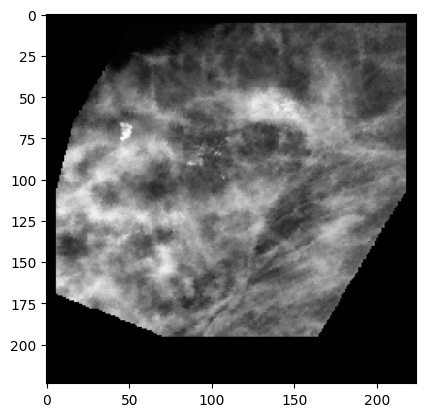

In [200]:
# Define the data augmentation pipeline
data_transforms = transforms.Compose([
    transforms.RandomRotation(40, fill=0, interpolation=transforms.InterpolationMode.NEAREST),  # Rotation with nearest fill mode
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), fill=0, interpolation=transforms.InterpolationMode.NEAREST),  # Width and Height shift with nearest fill mode
    transforms.RandomAffine(degrees=0, shear=20, fill=0, interpolation=transforms.InterpolationMode.NEAREST),  # Shear with nearest fill mode
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), fill=0, interpolation=transforms.InterpolationMode.NEAREST),  # Zoom with nearest fill mode
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

image = Image.open(calc_df['original_image'][210])
image = img_pipeline(image)
image = transforms.ToPILImage()(image)
augmented_image = data_transforms(image)
augmented_image = augmented_image.permute(1, 2, 0).numpy()

plt.imshow(augmented_image, cmap='gray')
plt.show()
